Visualize EV results - average of 40 runs, time since wind change

## load data
based on JH_model_fitting.py

In [16]:
import os
import sys
import numpy as np

# eval_pkl = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/noisy3x5b5_more_offsets.pkl'
# eval_pkl = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/noisy3x5b5_original_inits.pkl'
eval_pkl = '/src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb/poisson_noisy3x5b5.pkl'
obs_pkl = eval_pkl.replace(".pkl", "_observability_test.pkl")
# noisy3x5b5_observability_test_original_inits.pkl
eval_folder = os.path.dirname(eval_pkl) + '/'
dataset = os.path.basename(eval_pkl).replace('.pkl', '')

model_name = os.path.basename(os.path.dirname(eval_folder)).split('_')[1]
print(f"now visualizing {model_name}, {dataset}")
# check if obs file exists
if not os.path.exists(obs_pkl):
    print(f"Observability file {obs_pkl} not found")


now visualizing 14421, poisson_noisy3x5b5


In [17]:
# load pkl file
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import tamagotchi.eval.log_analysis as log_analysis

# with open(obs_pkls[0], 'rb') as f_handle:
with open(obs_pkl, 'rb') as f_handle:
    observability_tupl = pickle.load(f_handle)
    print(f"Found {len(observability_tupl)} trials in observability results")
# with open(eval_pkls[0], 'rb') as f_handle:
with open(eval_pkl, 'rb') as f_handle:
    # based on open_loop_perturbation.py
    selected_df = log_analysis.get_selected_df(eval_folder, [dataset],
                                            n_episodes_home=720,
                                            # n_episodes_home=240,
                                            n_episodes_other=240,  
                                            balanced=False,
                                            oob_only=False,
                                            verbose=True)

    traj_df_stacked, stacked_neural_activity = log_analysis.get_traj_and_activity_and_stack_them(selected_df, 
                                                                                                obtain_neural_activity = True, 
                                                                                                obtain_traj_df = True, 
                                                                                                get_traj_tmp = True,
                                                                                                extended_metadata = True) # get_traj_tmp 
    print(traj_df_stacked.shape)
    print(stacked_neural_activity.shape)
for item in observability_tupl:
    EV_no_nan, t_sim, x_sim, window_size, eps_idx = item
    
ls_EV_no_nan, ls_t_sim, ls_x_sim, ls_window_size, ls_eps_idx = zip(*observability_tupl)

# Preprocess the trajectory data
# select episodes that have observability matrices
eps_at = [True for ep_i in traj_df_stacked['ep_idx'] ]
subset_traj_df_stacked = traj_df_stacked[eps_at]
subset_stacked_neural_activity = stacked_neural_activity[eps_at]

# for every episode, drop the last row
subset_traj_df_stacked.reset_index(drop=True, inplace=True)
last_rows = subset_traj_df_stacked.groupby('ep_idx').tail(1).index
print('dropping', len(last_rows), 'rows, which are the last rows of each episode') # drop because there's no terminal+1 state
# drop the last row of each episode
filtered_df = subset_traj_df_stacked.drop(index=last_rows)
filtered_neural_activity = np.delete(subset_stacked_neural_activity, last_rows, axis=0)

# calculate time since last wind change
    # based on /src/JH_boilerplate/agent_evaluatiion/traj_analysis_preprocess.ipynb
filtered_df = filtered_df.groupby('ep_idx').apply(log_analysis.calc_time_since_last_wind_change).reset_index(drop=True)

# # create time column in filtered_df to match with EV_no_nan, starting from 0 to trial end 
filtered_df['time'] = filtered_df.groupby('ep_idx')['t_val'].transform(lambda x: x - x.iloc[0])
filtered_df['time'] = filtered_df['time'].round(2)
filtered_df['turn'] = (filtered_df['turn'] * 2) - 1 # center the turn values at 0 (from 0~1 to -1~1)

# first derivative of actions based on obs_df calculations 
filtered_df['heading_phi'] = np.angle(filtered_df['agent_angle_x']+ 1j*filtered_df['agent_angle_y'], deg=False)
filtered_df['heading_phi_unwrap'] = np.unwrap(np.angle(filtered_df['agent_angle_x']+ 1j*filtered_df['agent_angle_y'], deg=False))
filtered_df['angular_velocity'] = filtered_df.groupby('ep_idx')['heading_phi_unwrap'].diff() # not really v - just once step difference
filtered_df['angular_acceleration'] = filtered_df.groupby('ep_idx')['angular_velocity'].diff()
filtered_df['turn_dt'] = filtered_df['angular_acceleration'] / (6 * np.pi * 0.04) # given angular acceleration, calculate turn_dt, i.e. chaneg in turn action 
filtered_df['turn_dt'] = filtered_df['turn_dt'].abs() # 
filtered_df['step_dt'] = filtered_df.groupby('ep_idx')['step'].diff()

# drop rows with NaN
# filtered_df.dropna(inplace=True)

print("filtered_df shape", filtered_df.shape)
print("filtered_neural_activity shape", filtered_neural_activity.shape)

# Preprocess the EV data 
# stack the EV data
ls_EV_no_nan = [df.assign(ep_idx=ep_idx) for df, ep_idx in zip(ls_EV_no_nan, ls_eps_idx)]
EV_no_nan = pd.concat(ls_EV_no_nan)
print(EV_no_nan.shape)
# Merge with filtered_dfa
EV_no_nan['time'] = EV_no_nan['time'].round(2)
EV_no_nan = EV_no_nan.merge(filtered_df[['ep_idx', 'time', 'time_since_last_wind_change', 
                                         'odor_lastenc', 'odor_01', 'step', 'turn', 'step_dt', 'turn_dt', 'loc_x', 'loc_y', 'wind_angle_ground_theta']], on=['ep_idx', 'time'], how='inner')
print(EV_no_nan.shape)
'''
# # Preprocess action data
# # get speed and acceleration
# obs_df = pd.DataFrame()
# obs_df['ep_idx'] = filtered_df['ep_idx']
# obs_df['step'] = filtered_df['step'] # squashed action
# obs_df['step_dt'] = obs_df.groupby('ep_idx')['step'].diff()
# obs_df['speed'] = filtered_df['step']*2 # in m/s unit
# obs_df['acceleration'] = obs_df.groupby('ep_idx')['speed'].diff()
# obs_df['turn'] = ((filtered_df['turn'] - 0.5)*2)
# obs_df['angular_velocity_turn'] = obs_df['turn'] * (6*np.pi) # in rad/s unit

# # obs_df['acceleration'] = obs_df['acceleration'].fillna(0) # TODO check timing 

# # calculate angular velocity and angular acceleration
# obs_df['heading_phi'] = np.angle(filtered_df['agent_angle_x']+ 1j*filtered_df['agent_angle_y'], deg=False)
# obs_df['heading_phi_unwrap'] = np.unwrap(np.angle(filtered_df['agent_angle_x']+ 1j*filtered_df['agent_angle_y'], deg=False))
# obs_df['angular_velocity'] = obs_df.groupby('ep_idx')['heading_phi_unwrap'].diff()
# obs_df['angular_acceleration'] = obs_df.groupby('ep_idx')['angular_velocity'].diff()
# # obs_df['angular_acceleration'] = obs_df['angular_acceleration'].fillna(0) # TODO check timing

# # set 10% trials as test set
# test_idx = np.random.choice(obs_df['ep_idx'].unique(), int(0.1*len(obs_df['ep_idx'].unique())), replace=False)
# obs_df['train_test_label'] = 'train'
# obs_df.loc[obs_df['ep_idx'].isin(test_idx), 'train_test_label'] = 'test'
# # print how many train and test episodes
# print(obs_df.groupby('train_test_label')['ep_idx'].nunique())
# print(obs_df[obs_df['train_test_label']=='test'].groupby('train_test_label')['ep_idx'].unique())

# input_df = pd.DataFrame()
# # observations of the agent
# input_df['ep_idx'] = filtered_df['ep_idx']
# input_df['app_wind_x'] = filtered_df['wind_x_obs']
# input_df['app_wind_y'] = filtered_df['wind_y_obs']
# input_df['odor'] = filtered_df['odor_eps_log']
# input_df['allo_head_phi_x'] = filtered_df['agent_angle_x']
# input_df['allo_head_phi_y'] = filtered_df['agent_angle_y']
# input_df['ego_drift_x'] = filtered_df['ego_course_direction_x']
# input_df['ego_drift_y'] = filtered_df['ego_course_direction_y']
# # possible latents to include
# input_df['min_EV_zeta'] = EV_no_nan['zeta']
# input_df['time_since_last_wind_change'] = EV_no_nan['time_since_last_wind_change']
# input_df['acceleration'] = obs_df['acceleration']
# input_df['angular_acceleration'] = obs_df['angular_acceleration']

# # set 10% trials as test set
# input_df['train_test_label'] = obs_df['train_test_label']
# print(input_df.groupby('train_test_label')['ep_idx'].nunique())
# print(obs_df[obs_df['train_test_label']=='test'].groupby('train_test_label')['ep_idx'].unique())
# train_idx = input_df[input_df['train_test_label']=='train']['ep_idx'].unique()
# # drop rows with NaN
# input_df.dropna(inplace=True)
# obs_df.dropna(inplace=True)
'''

Found 354 trials in observability results
Found                             idx  ep_length  log
dataset            outcome                     
poisson_noisy3x5b5 HOME     354        354  354
                   OOB      488        488  488
                   OOT      118        118  118 in /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb//poisson_noisy3x5b5.pkl, after filter by min 0 steps
Found                             idx  ep_length  log
dataset            outcome                     
poisson_noisy3x5b5 HOME     354        354  354
                   OOB      488        488  488
                   OOT      118        118  118 in /src/data/wind_sensing/apparent_wind_visual_feedback/sw_dist_logstep_wind_0.001_debug_yes_vec_norm_train_actor_std/eval/plume_14421_37e2cd4be4c96943d0341849b40f81eb//poisson_noisy3x5b5.pkl, after selecting specific number of episodes
model_di

594it [00:29, 20.09it/s]


(129537, 88)
(129537, 64)
dropping 594 rows, which are the last rows of each episode
filtered_df shape (128943, 96)
filtered_neural_activity shape (128943, 64)
(65346, 7)
(65346, 17)


"\n# # Preprocess action data\n# # get speed and acceleration\n# obs_df = pd.DataFrame()\n# obs_df['ep_idx'] = filtered_df['ep_idx']\n# obs_df['step'] = filtered_df['step'] # squashed action\n# obs_df['step_dt'] = obs_df.groupby('ep_idx')['step'].diff()\n# obs_df['speed'] = filtered_df['step']*2 # in m/s unit\n# obs_df['acceleration'] = obs_df.groupby('ep_idx')['speed'].diff()\n# obs_df['turn'] = ((filtered_df['turn'] - 0.5)*2)\n# obs_df['angular_velocity_turn'] = obs_df['turn'] * (6*np.pi) # in rad/s unit\n\n# # obs_df['acceleration'] = obs_df['acceleration'].fillna(0) # TODO check timing \n\n# # calculate angular velocity and angular acceleration\n# obs_df['heading_phi'] = np.angle(filtered_df['agent_angle_x']+ 1j*filtered_df['agent_angle_y'], deg=False)\n# obs_df['heading_phi_unwrap'] = np.unwrap(np.angle(filtered_df['agent_angle_x']+ 1j*filtered_df['agent_angle_y'], deg=False))\n# obs_df['angular_velocity'] = obs_df.groupby('ep_idx')['heading_phi_unwrap'].diff()\n# obs_df['angular_

## sanity check time since wind change - look at rows around time of wind change

In [18]:
wind_change_index = EV_no_nan[EV_no_nan['time_since_last_wind_change'] == 0].index

look_at_idx = [[i-1, i, i+1]for i in wind_change_index]

# squash look_at_idx
look_at_idx = [item for sublist in look_at_idx for item in sublist]
see = EV_no_nan.loc[look_at_idx]
see.head(20)

,time,time_initial,v_para,v_perp,w,zeta,ep_idx,time_since_last_wind_change,odor_lastenc,odor_01,step,turn,step_dt,turn_dt,loc_x,loc_y,wind_angle_ground_theta
22,0.88,0.68,45545.203345,217.357164,5775.060889,1512.481962,773,0.92,0,1,0.954189,-0.059085,0.003410,0.025773,7.996858,1.930038,0.524323
23,0.92,0.72,171089.207218,172.366918,21704.398399,2240.803117,773,0.00,0,1,0.956007,-0.031175,0.001817,0.014536,7.940077,1.926028,0.472387
24,0.96,0.76,169130.299767,0.113152,21585.792429,2371.008171,773,0.04,0,1,0.955296,-0.048034,-0.000711,0.008781,7.883356,1.923459,0.472387
90,3.60,3.40,5649.741797,13.151926,293.172940,28.996699,773,2.68,23,0,0.940702,-0.369138,0.018641,0.119358,5.646676,2.364585,0.472387
91,3.64,3.44,20590.716020,363.232233,954.422561,50.184531,773,0.00,24,0,0.951350,-0.184347,0.010649,0.096245,5.646783,2.291338,0.501711
92,3.68,3.48,82074.321107,3224.384581,3426.613624,85.399281,773,0.04,25,0,0.957607,-0.068848,0.006257,0.060156,5.644768,2.218176,0.501711
95,3.80,3.60,72563.607823,5170.633924,4293.592961,67.354918,773,0.16,28,0,0.955719,0.025618,-0.003356,0.003316,5.639912,1.998185,0.501711
96,3.84,3.64,58910.482381,4317.537804,4627.329961,71.573136,773,0.00,29,0,0.950156,0.013611,-0.005563,0.006254,5.631748,1.940793,0.645501
97,3.88,3.68,126890.957934,9259.811974,10488.580921,49.996634,773,0.04,30,0,0.943751,0.000438,-0.006405,0.006861,5.623733,1.883891,0.645501
102,4.08,3.88,242974.417332,4258.626088,29804.829677,385.472411,773,0.24,35,0,0.948327,-0.086968,0.002150,0.008385,5.548490,1.611181,0.645501


check if wind change detection is working

In [19]:
# based on /src/JH_boilerplate/agent_evaluatiion/wind_encoding_perturbation/analyze_OL_perturb_trajj.ipynb
def tidx_around_wind_change(df_traj, around_range=40, drop_incomplete=True, verbose=False):
    # df_traj contains the KL divergence data and the time since the last wind change
    # get +- around_range index around which wind changed
    # returns df_traj_aligned: a subset of df_traj, with only the rows around which wind changed, and plot_tidx around wind change, instead of actual tidx
    idx_where_wind_changed = df_traj[df_traj['time_since_last_wind_change']==0].index
    if verbose:
        print(f"starting with df.shape {df_traj.shape}")
        print(f"with {df_traj['ep_idx'].nunique()} eps")
        # max_rep = np.max(np.array([int(hash.split('_')[-2]) for hash in df_traj['ep_idx']])) + 1
        # print(f"and up to {max_rep} reps")
        print(f"total number of wind change {len(idx_where_wind_changed)}")
    if drop_incomplete:
        print(f"dropping incomplete time windows, where +- {around_range} around wind change is out of range")
    
    # get index around which wind changed
    df_traj_grouped = df_traj.groupby('ep_idx')
    idx_around_wind_change = []
    tidx_for_plotting = []
    eligible_wind_change_idx = []
    for _, ep_df in df_traj_grouped:
        idx_where_wind_changed = ep_df[ep_df['time_since_last_wind_change']==0].index
        for wind_changed_idx in idx_where_wind_changed:
            # check if -5/+5 is out of range
            upper_bound = wind_changed_idx + around_range
            lower_bound = wind_changed_idx - around_range
            if upper_bound >= ep_df.index.max():
                if drop_incomplete:
                    continue
                upper_bound = ep_df.index.max()
            if lower_bound < ep_df.index.min():
                if drop_incomplete: 
                    continue
                lower_bound = ep_df.index.min()
            # get index around which wind changed
            now_idx_range = [i for i in range(lower_bound, upper_bound + 1)] # loc index of rows around wind change
            idx_around_wind_change.append(now_idx_range)
            tidx_for_plotting.append(list(np.array(now_idx_range) - wind_changed_idx)) # time index aligned to wind change, where wind change is 0 and prior to wind change is negative
            eligible_wind_change_idx.append(wind_changed_idx)
    # subset df and add plot_tidx
    idx_around_wind_change = [item for sublist in idx_around_wind_change for item in sublist]
    sub_df = df_traj.loc[idx_around_wind_change]
    sub_df['plot_tidx'] = [item for sublist in tidx_for_plotting for item in sublist]
    print(f"[NOTE]: number of eligible unique wind change instances {len(set(eligible_wind_change_idx))}")
    if verbose:
        print(f"returning sub_df.shape {sub_df.shape}")
        print(f"with {sub_df['ep_idx'].nunique()} eps")
        # intersection bewteen eps in sub_df and eps in df_traj
        
        print(f"eps {set(df_traj['ep_idx'].unique()) - set(sub_df['ep_idx'].unique())} did not have any eligible wind change windows")
    return sub_df

EV_no_nan_around = tidx_around_wind_change(EV_no_nan, around_range=40, drop_incomplete=False, verbose=True)
EV_no_nan_around.head(10)

starting with df.shape (65346, 17)
with 354 eps
total number of wind change 2180


[NOTE]: number of eligible unique wind change instances 2180
returning sub_df.shape (154887, 18)
with 354 eps
eps set() did not have any eligible wind change windows


,time,time_initial,v_para,v_perp,w,zeta,ep_idx,time_since_last_wind_change,odor_lastenc,odor_01,step,turn,step_dt,turn_dt,loc_x,loc_y,wind_angle_ground_theta,plot_tidx
64395,0.00,0.00,52.898500,2.057831,5.766865,0.597179,0,0.04,0,1,0.243880,-0.806689,NaN,NaN,4.038530,0.249788,0.505882,-1
64396,0.04,0.00,52.898500,2.057831,5.766865,0.597179,0,0.00,0,1,0.322663,-0.848510,0.078783,NaN,4.078493,0.238964,0.538556,0
64397,0.08,0.00,52.898500,2.057831,5.766865,0.597179,0,0.04,0,1,0.452986,-0.812121,0.130323,0.018953,4.118426,0.213891,0.538556,1
64398,0.12,0.00,52.898500,2.057831,5.766865,0.597179,0,0.08,0,1,0.461668,-0.789714,0.008681,0.011670,4.148463,0.183316,0.538556,2
64399,0.16,0.00,52.898500,2.057831,5.766865,0.597179,0,0.12,0,0,0.466099,-0.816342,0.004431,0.013869,4.166803,0.150840,0.538556,3
64400,0.20,0.00,52.898500,2.057831,5.766865,0.597179,0,0.16,1,0,0.494667,-0.824981,0.028568,0.004499,4.172544,0.118502,0.538556,4
64401,0.24,0.04,33.219236,5.227707,4.111347,0.856084,0,0.20,2,0,0.520455,-0.794831,0.025787,0.015703,4.166269,0.090532,0.538556,5
64402,0.28,0.08,22.764697,5.330466,3.403923,0.811409,0,0.24,3,0,0.584929,-0.740004,0.064475,0.028556,4.147470,0.068320,0.538556,6
64403,0.32,0.12,31.854817,10.452773,6.196259,2.065230,0,0.28,4,0,0.695316,-0.597396,0.110386,0.074275,4.115241,0.052450,0.538556,7
64404,0.36,0.16,77.039732,30.037894,21.069241,8.925071,0,0.32,5,0,0.828225,-0.353722,0.132910,0.126913,4.070325,0.041383,0.538556,8


# minEV evolution at wind change

## plot all minEV traces

(1, 1)


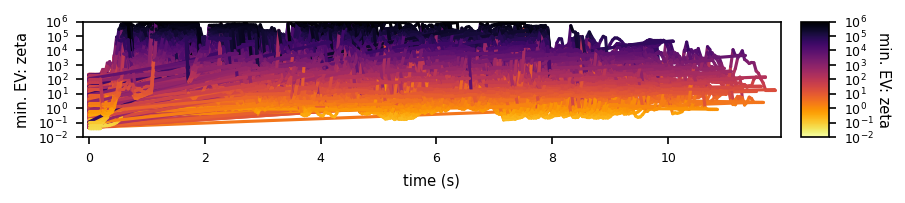

In [35]:
states = ['zeta']
n_state = len(states)
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline
fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
print(ax.shape)
cmap = 'inferno_r'

max_ev = np.max(EV_no_nan['zeta'].values)
min_ev = np.min(EV_no_nan['zeta'].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    # colorline(x_sim['x'], x_sim['y'], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(EV_no_nan['time'], EV_no_nan[state_name].values, EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)

    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time (s)', fontsize=7)
    a.set_xlim(-0.1, EV_no_nan['time'].max() + 0.1)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

## plot one trace at wind change

### plot one trial color by time

(1, 1)


NameError: name 'log_tick_low' is not defined

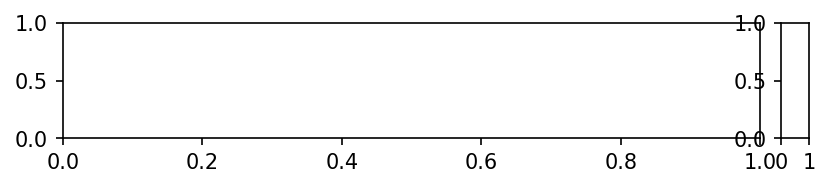

In [4]:
subset_df = EV_no_nan[EV_no_nan['ep_idx'] == 160]
states = ['zeta']
n_state = len(states)
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline
fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
print(ax.shape)
cmap = 'inferno_r'

max_ev = np.max(subset_df['time'].values)
min_ev = np.min(subset_df['time'].values)

# log_tick_high = int(np.ceil(np.log10(max_ev)))
# log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.Normalize(min_ev, max_ev)
# cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['time_since_last_wind_change'], subset_df[state_name].values, subset_df['time'].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)

    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since last w change (s)', fontsize=7)
    a.set_xlim(-0.1, subset_df['time_since_last_wind_change'].max() + 0.1)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

## plot avg. min EV around wind change

   time_since_last_wind_change          zeta
0                         0.00    798.061798
1                         0.04    723.537296
2                         0.08    813.075582
3                         0.12    945.705085
4                         0.16   1460.521188
5                         0.20  29165.388092
6                         0.24  26982.790575
7                         0.28  28047.309804
8                         0.32  27867.983531
9                         0.36  28586.102367
(1, 1)


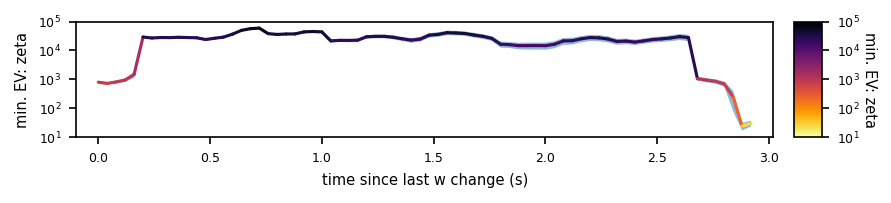

In [21]:
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan.copy()
subset_df = subset_df.groupby('time_since_last_wind_change')['zeta'].mean().reset_index()
print(subset_df.head(10))
subset_df['std'] = EV_no_nan.groupby('time_since_last_wind_change').std().reset_index()['zeta']
subset_df['ste'] = EV_no_nan.groupby('time_since_last_wind_change').sem().reset_index()['zeta']
states = ['zeta']
n_state = len(states)
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline
fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
print(ax.shape)
cmap = 'inferno_r'

max_ev = np.max(subset_df['zeta'].values)
min_ev = np.min(subset_df['zeta'].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['time_since_last_wind_change'], subset_df[state_name].values, subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['time_since_last_wind_change'], subset_df[state_name].values-subset_df['ste'], subset_df[state_name].values+subset_df['ste'], alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since last w change (s)', fontsize=7)
    a.set_xlim(-0.1, subset_df['time_since_last_wind_change'].max() + 0.1)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

## plot OFF/ON traces

(2,)


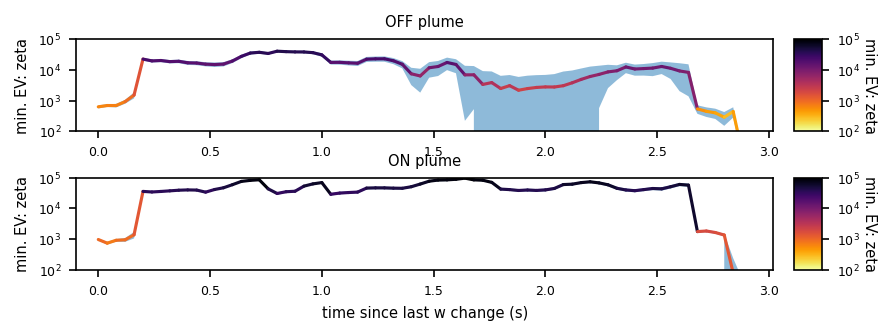

In [20]:
# plot average EV over time since last wind change with std ON plume


import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline
fig, ax = plt.subplots(2, 1, figsize=(6, 2), dpi=150) # 2 rows, off and on plume
print(ax.shape)
ax = np.atleast_2d(ax)
ax = ax.reshape(-1, 1)
cmap = 'inferno_r'

max_ev = np.max(subset_df['zeta'].values)
min_ev = np.min(subset_df['zeta'].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
# log_tick_low = 3
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

state_name = 'zeta'
for n in range(2): # ON vs OFF plume
    subset_df = EV_no_nan[EV_no_nan['odor_01'] == n]
    subset_df = subset_df.groupby('time_since_last_wind_change')['zeta'].mean().reset_index()
    subset_df['std'] = EV_no_nan.groupby('time_since_last_wind_change').std().reset_index()['zeta']
    subset_df['ste'] = EV_no_nan.groupby('time_since_last_wind_change').sem().reset_index()['zeta']
    colorline(subset_df['time_since_last_wind_change'], subset_df[state_name].values, subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['time_since_last_wind_change'], subset_df[state_name].values-subset_df['ste'], subset_df[state_name].values+subset_df['ste'], alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    # add label to row
    if n == 0:
        ax[n, 0].set_title('OFF plume')
    else:
        ax[n, 0].set_title('ON plume')
    # make title smaller
    ax[n, 0].title.set_size(7)


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlim(-0.1, subset_df['time_since_last_wind_change'].max() + 0.1)
ax[1,0].set_xlabel('time since last w change (s)', fontsize=7)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5)

plt.show()

Maybe a dip after wind changes, and can check by plotting the trace preceeding to the wind change. But, the scale of the trace is problematic. One average wind should be hardly observable. It still may be possible if collected over a long time, since this is just min. EV and variance can be smoothed out by averaging.

## plot at +- wind change 

### preprocess 

In [22]:
# based on /src/JH_boilerplate/agent_evaluatiion/wind_encoding_perturbation/analyze_OL_perturb_trajj.ipynb
def tidx_around_wind_change(df_traj, around_range=40, drop_incomplete=True, drop_close_to_trial_init=False, verbose=False):
    # df_traj contains the KL divergence data and the time since the last wind change
    # get +- around_range index around which wind changed
    # returns df_traj_aligned: a subset of df_traj, with only the rows around which wind changed, and plot_tidx around wind change, instead of actual tidx
        # drop_close_to_trial_init: plot_tidx marking is invalid if the wind change time is too close to the trial init, -40 plot_tidx could mean 0.8s from the last wind change
            # this option checks the lowest bound of the plot_tidx, if its corresponding time is less than 1s, drop the whole window
    idx_where_wind_changed = df_traj[df_traj['time_since_last_wind_change']==0].index
    if verbose:
        print(f"starting with df.shape {df_traj.shape}")
        print(f"with {df_traj['ep_idx'].nunique()} eps")
        # max_rep = np.max(np.array([int(hash.split('_')[-2]) for hash in df_traj['ep_idx']])) + 1
        # print(f"and up to {max_rep} reps")
        print(f"total number of wind change {len(idx_where_wind_changed)}")
    if drop_incomplete:
        print(f"dropping incomplete time windows, where +- {around_range} around wind change is out of range")
    
    # get index around which wind changed
    df_traj_grouped = df_traj.groupby('ep_idx')
    idx_around_wind_change = []
    tidx_for_plotting = []
    eligible_wind_change_idx = []
    for _, ep_df in df_traj_grouped:
        idx_where_wind_changed = ep_df[ep_df['time_since_last_wind_change']==0].index
        for i, wind_changed_idx in enumerate(idx_where_wind_changed):
            # check if -5/+5 is out of range
            upper_bound = wind_changed_idx + around_range
            lower_bound = wind_changed_idx - around_range
            if upper_bound >= ep_df.index.max():
                if drop_incomplete:
                    continue
                upper_bound = ep_df.index.max()
            if lower_bound < ep_df.index.min():
                if drop_incomplete: 
                    continue
                lower_bound = ep_df.index.min()
            # check if the time elasped at the lower bound is too close to trial init
            if ep_df['time'].loc[lower_bound] < 1:
                if drop_close_to_trial_init:
                    continue
            # check if time_since_last_wind_change is 0 at the lower bound
            if ep_df['time_since_last_wind_change'].loc[lower_bound] < 1:
                # print(f"wind_changed_idx {wind_changed_idx},  {ep_df['time_since_last_wind_change'].loc[lower_bound]}, lower_bound {lower_bound}, {wind_changed_idx - lower_bound}")
                continue
            # check if between lower_bound and wind_changed_idx, time_since_last_wind_change is not 0
            if 0 in ep_df['time_since_last_wind_change'].loc[lower_bound:wind_changed_idx-1].values:
                continue
            if 0 in ep_df['time_since_last_wind_change'].loc[wind_changed_idx+1:upper_bound].values:
                continue
            # get index around which wind changed
            now_idx_range = [i for i in range(lower_bound, upper_bound + 1)] # loc index of rows around wind change
            idx_around_wind_change.append(now_idx_range)
            tidx_for_plotting.append(list(np.array(now_idx_range) - wind_changed_idx)) # time index aligned to wind change, where wind change is 0 and prior to wind change is negative
            eligible_wind_change_idx.append(wind_changed_idx)
    # subset df and add plot_tidx
    idx_around_wind_change = [item for sublist in idx_around_wind_change for item in sublist]
    sub_df = df_traj.loc[idx_around_wind_change]
    sub_df['plot_tidx'] = [item for sublist in tidx_for_plotting for item in sublist]
    print(f"[NOTE]: number of eligible unique wind change instances {len(set(eligible_wind_change_idx))}")
    if verbose:
        print(f"returning sub_df.shape {sub_df.shape}")
        print(f"with {sub_df['ep_idx'].nunique()} eps")
        # intersection bewteen eps in sub_df and eps in df_traj
        
        print(f"eps {set(df_traj['ep_idx'].unique()) - set(sub_df['ep_idx'].unique())} did not have any eligible wind change windows")
    return sub_df

EV_no_nan_around = tidx_around_wind_change(EV_no_nan, around_range=10, drop_incomplete=True, drop_close_to_trial_init=True, verbose=True)
# EV_no_nan_around.head(10)

starting with df.shape (65346, 17)
with 354 eps
total number of wind change 2180
dropping incomplete time windows, where +- 10 around wind change is out of range
[NOTE]: number of eligible unique wind change instances 349
returning sub_df.shape (7329, 18)
with 279 eps
eps {0, 1, 2, 3, 153, 5, 6, 7, 8, 137, 10, 11, 12, 13, 14, 139, 141, 17, 18, 142, 20, 21, 22, 143, 145, 25, 26, 27, 28, 148, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 48, 53, 60, 61, 155, 65, 66, 67, 68, 69, 70, 71, 72, 73, 321, 75, 76, 77, 78, 460, 461, 465, 341, 470, 151, 346, 475, 357, 157, 120, 121, 126} did not have any eligible wind change windows


#### sanity check    

Text(0.5, 1.0, 'time elapsed at plot_tidx = nan')

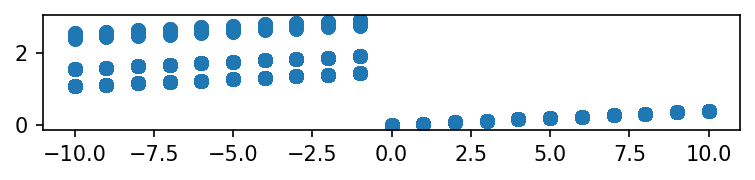

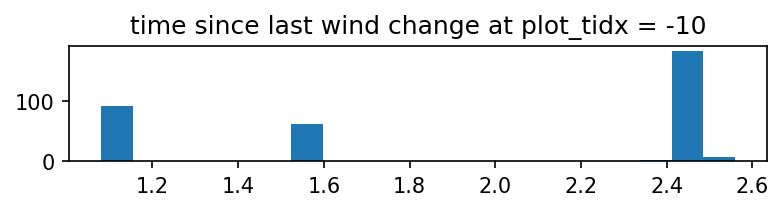

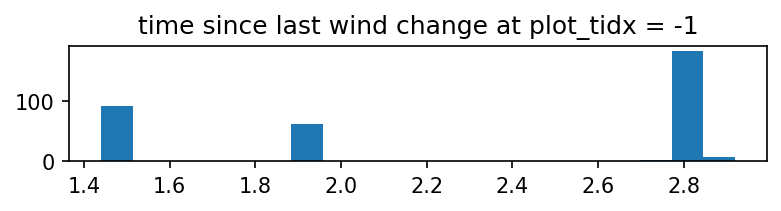

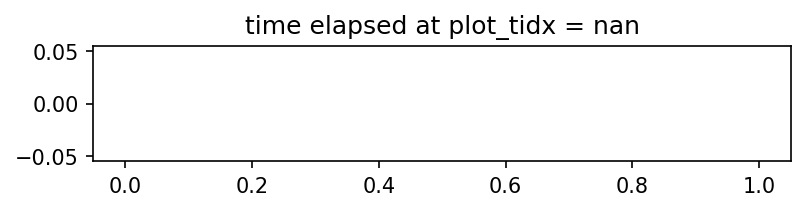

In [23]:
# plot y axis time since last wind change, x axis plot_tidx
import matplotlib.pyplot as plt
subset_df = EV_no_nan_around.copy()
fig, ax = plt.subplots(1, 1, figsize=(6, 1), dpi=150)

plt.scatter(subset_df['plot_tidx'], subset_df['time_since_last_wind_change'])

# plot histogram of time since last wind change at the smallest plot_tidx
subset_df = EV_no_nan_around.copy()
subset_df = subset_df[subset_df['plot_tidx'] == subset_df['plot_tidx'].min()]
fig, ax = plt.subplots(1, 1, figsize=(6, 1), dpi=150)
plt.hist(subset_df['time_since_last_wind_change'], bins=20)
plt.title(f"time since last wind change at plot_tidx = {subset_df['plot_tidx'].min()}")

# plot histogram of time since last wind change at the smallest plot_tidx
subset_df = EV_no_nan_around.copy()
subset_df = subset_df[subset_df['plot_tidx'] == -1]
fig, ax = plt.subplots(1, 1, figsize=(6, 1), dpi=150)
plt.hist(subset_df['time_since_last_wind_change'], bins=20)
plt.title(f"time since last wind change at plot_tidx = {subset_df['plot_tidx'].min()}")

# plot histogram of time since last wind change at the smallest plot_tidx
subset_df = EV_no_nan_around.copy()
subset_df = subset_df[subset_df['plot_tidx'] == -30]
fig, ax = plt.subplots(1, 1, figsize=(6, 1), dpi=150)
plt.hist(subset_df['time'], bins=20)
plt.title(f"time elapsed at plot_tidx = {subset_df['plot_tidx'].min()}") # use this to pick threshold for drop_close_to_trial_init


In [14]:
# pd.DataFrame(np.round(EV_no_nan_around[EV_no_nan_around['ep_idx']==83]['time'], 2)).value_counts()
see = pd.DataFrame(EV_no_nan_around[EV_no_nan_around['ep_idx']==83][['plot_tidx', 'time_since_last_wind_change']])
see['time_since_last_wind_change'] = see['time_since_last_wind_change'].round(2)
see
# see = see.value_counts()
# see.to_csv('/src/see.csv')


,plot_tidx,time_since_last_wind_change


### plot

       time  time_initial        v_para       v_perp             w  \
51043  5.52          5.32  46678.653324  3764.439408  15725.246306   
51044  5.56          5.36    577.095732    46.476862    271.818264   
51045  5.60          5.40    276.477233    19.870507    307.629022   
51046  5.64          5.44    213.123805    14.972912     93.461988   
51047  5.68          5.48    184.862166    11.752602     42.613142   
51048  5.72          5.52    205.810880    11.766953     34.373984   
51049  5.76          5.56    163.779886     8.810416     32.698371   
51050  5.80          5.60    175.685789     8.696791     12.857507   
51051  5.84          5.64     73.958765     3.507519     12.626045   
51052  5.88          5.68     68.842598     3.036716     13.051132   

              zeta  ep_idx  time_since_last_wind_change  odor_lastenc  \
51043  5755.968482       4                         2.44            40   
51044   303.919690       4                         2.48            41   
51045   41

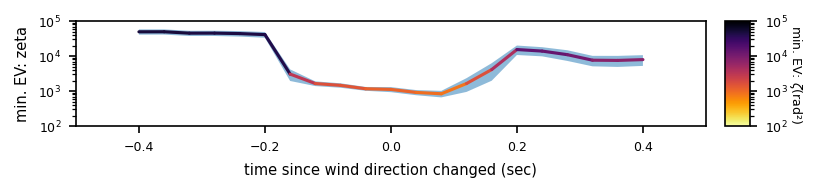

In [24]:
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan_around.copy()
# subset_df['turn_dt'].fillna(0, inplace=True) # try dropping the first nan at the first row. fillna on turn_dt, s.t. there the only nans are the first row of each episode in column step_dt
# subset_df.dropna(inplace=True)                      # NOTE: this is to see if there high observability prior to wind change is due to the first row of each episode - not the case
print(subset_df.head(10))
subset_df = subset_df.groupby('plot_tidx')['zeta'].mean().reset_index()
subset_df['std'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['zeta']
subset_df['ste'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['zeta']
subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04
states = ['zeta']
n_state = len(states)
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline
fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
print(ax.shape)
cmap = 'inferno_r'

max_ev = np.max(subset_df['zeta'].values)
min_ev = np.min(subset_df['zeta'].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['plot_tidx'], subset_df[state_name].values, subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['plot_tidx'], subset_df[state_name].values-subset_df['ste'], subset_df[state_name].values+subset_df['ste'], alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + r'$\zeta$ (rad)', rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since wind direction changed (sec)', fontsize=7)
    a.set_xlim(subset_df['plot_tidx'].min() -0.1, subset_df['plot_tidx'].max() + 0.1)
    # greek letter zeta
    cbar.set_label('min. EV: ' + r'$\zeta$' + '(rad\u00B2)', rotation=270, fontsize=6, labelpad=8)
    
fig.subplots_adjust(left=0.15, bottom=0.2, right=0.85, top=0.9, wspace=0.5, hspace=0.4)

# plt.show()
# plt.savefig('/src/tools/pybounds/examples/plots/obs.png')

### plot window shifted

In [ ]:
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan_around.copy()
# subset_df['turn_dt'].fillna(0, inplace=True) # try dropping the first nan at the first row. fillna on turn_dt, s.t. there the only nans are the first row of each episode in column step_dt
# subset_df.dropna(inplace=True)                      # NOTE: this is to see if there high observability prior to wind change is due to the first row of each episode - not the case
print(subset_df.head(10))
subset_df = subset_df.groupby('plot_tidx')['zeta'].mean().reset_index()
subset_df['std'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['zeta']
subset_df['ste'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['zeta']
subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04
states = ['zeta']
n_state = len(states)
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline
fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
print(ax.shape)
cmap = 'inferno_r'

max_ev = np.max(subset_df['zeta'].values)
min_ev = np.min(subset_df['zeta'].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['plot_tidx'], subset_df[state_name].values, subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['plot_tidx'], subset_df[state_name].values-subset_df['ste'], subset_df[state_name].values+subset_df['ste'], alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + r'$\zeta$ (rad)', rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since wind direction changed (sec)', fontsize=7)
    a.set_xlim(subset_df['plot_tidx'].min() -0.1, subset_df['plot_tidx'].max() + 0.1)
    # greek letter zeta
    cbar.set_label('min. EV: ' + r'$\zeta$' + '(rad\u00B2)', rotation=270, fontsize=6, labelpad=8)
    
fig.subplots_adjust(left=0.15, bottom=0.2, right=0.85, top=0.9, wspace=0.5, hspace=0.4)

# plt.show()
# plt.savefig('/src/tools/pybounds/examples/plots/obs.png')

## plot min EV since wind change

(1, 1)


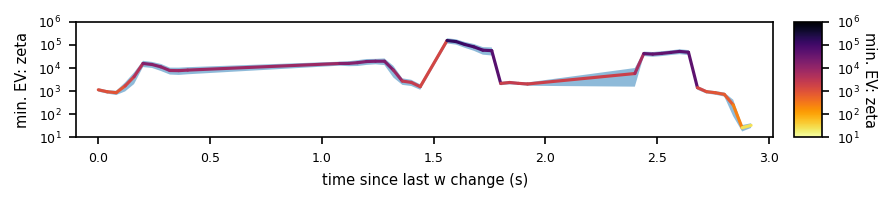

In [9]:
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan_around.copy()
subset_df = subset_df.groupby('time_since_last_wind_change')['zeta'].mean().reset_index()
# print(subset_df.head(10))
subset_df['std'] = EV_no_nan_around.groupby('time_since_last_wind_change').std().reset_index()['zeta']
subset_df['ste'] = EV_no_nan_around.groupby('time_since_last_wind_change').sem().reset_index()['zeta']
states = ['zeta']
n_state = len(states)
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline
fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
print(ax.shape)
cmap = 'inferno_r'

max_ev = np.max(subset_df['zeta'].values)
min_ev = np.min(subset_df['zeta'].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['time_since_last_wind_change'], subset_df[state_name].values, subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['time_since_last_wind_change'], subset_df[state_name].values-subset_df['ste'], subset_df[state_name].values+subset_df['ste'], alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since last w change (s)', fontsize=7)
    a.set_xlim(-0.1, subset_df['time_since_last_wind_change'].max() + 0.1)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

### plot actions at wind change

In [23]:

manual = EV_no_nan_around.copy()
# manual.dropna(inplace=True)      
manual = manual[manual['plot_tidx'] == 0][['step_dt', 'plot_tidx']]
manual['step_dt'].describe()


# # subset_df['turn_dt'].fillna(0, inplace=True) # try dropping the first nan at the first row. fillna on turn_dt, s.t. there the only nans are the first row of each episode in column step_dt
# subset_df.dropna(inplace=True)                      # NOTE: this is to see if there high observability prior to wind change is due to the first row of each episode - not the case
# # print(subset_df.head(10))
# subset_df = subset_df.groupby('plot_tidx')[['step_dt']].mean().reset_index()
# subset_df[['step_dt', 'plot_tidx']]

count    1407.000000
mean        0.001607
std         0.029666
min        -0.175246
25%        -0.004135
50%         0.000117
75%         0.003677
max         0.218597
Name: step_dt, dtype: float64

In [ ]:

manual = EV_no_nan_around.copy()
manual.dropna(inplace=True)      
manual = manual[manual['plot_tidx'] == 0][['step_dt', 'plot_tidx']]
manual['step_dt'].describe()


In [9]:

subset_df = EV_no_nan_around.copy()
# subset_df['turn_dt'].fillna(0, inplace=True) # try dropping the first nan at the first row. fillna on turn_dt, s.t. there the only nans are the first row of each episode in column step_dt
subset_df.dropna(inplace=True)                      # NOTE: this is to see if there high observability prior to wind change is due to the first row of each episode - not the case
# print(subset_df.head(10))
subset_df = subset_df.groupby('plot_tidx')[['zeta', 'step', 'turn', 'step_dt', 'turn_dt']].mean().reset_index()
subset_df[['step_dt', 'plot_tidx']][subset_df['plot_tidx'] == 0]

,step_dt,plot_tidx
30,0.001174,0


      time  time_initial         v_para        v_perp             w  \
7914  2.68          2.48    1281.075452     59.313385     92.047357   
7915  2.72          2.52    2628.642408    220.597090    192.909676   
7916  2.76          2.56   16802.577401   1798.627694   1220.806394   
7917  2.80          2.60  227151.128445  22237.489981  16658.147951   
7918  2.84          2.64  189466.644793  13258.329434  14519.579498   
7919  2.88          2.68  229992.178296  10990.718965  16457.053275   
7920  2.92          2.72   26942.107210    932.618094   3542.383152   
7921  2.96          2.76   79481.906289   2238.520575   9858.301394   
7922  3.00          2.80  138418.491814   3386.565583  16360.372075   
7923  3.04          2.84   60308.626553   1321.262768   6904.533246   

              zeta  ep_idx  time_since_last_wind_change  odor_lastenc  \
7914      3.805484      83                         2.64            46   
7915     18.282843      83                         2.68            47   

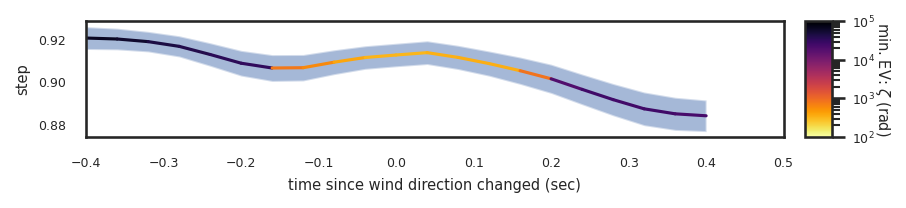

In [27]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline

# plot average of actions over time since last wind change
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan_around.copy()
subset_df['turn_dt'].fillna(0, inplace=True) # try dropping the first nan at the first row. fillna on turn_dt, s.t. there the only nans are the first row of each episode in column step_dt
subset_df.dropna(inplace=True)                      # NOTE: this is to see if there high observability prior to wind change is due to the first row of each episode - not the case
print(subset_df.head(10))
subset_df = subset_df.groupby('plot_tidx')[['zeta', 'step', 'turn', 'step_dt', 'turn_dt']].mean().reset_index()
# dispersion std
subset_df['std_zeta'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['zeta']
subset_df['std_step'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['step']
subset_df['std_step_dt'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['step_dt']
subset_df['std_turn'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['turn']
subset_df['std_turn_dt'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['turn_dt']
# dispersion ste
subset_df['ste_zeta'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['zeta']
subset_df['ste_step'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['step']
subset_df['ste_step_dt'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['step_dt']
subset_df['ste_turn'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['turn']
subset_df['ste_turn_dt'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['turn_dt']
# x-axis
subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04
states = ['step']
n_state = len(states)

fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
print(ax.shape)
cmap = 'inferno_r'
color_by = 'zeta'

# max, min, log, ticks for the colorbar
max_ev = np.max(subset_df[color_by].values)
min_ev = np.min(subset_df[color_by].values)
log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    dispersion_col = 'ste_' + state_name
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['plot_tidx'], subset_df[state_name].values, subset_df[color_by].values,  # x, y, color 
              ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['plot_tidx'], 
                          subset_df[state_name].values-subset_df[dispersion_col], 
                          subset_df[state_name].values+subset_df[dispersion_col], 
                          alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + r'$\zeta$ (rad)', rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    # set y label
    # ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    # ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel(state_name, fontsize=7)
    # ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since wind direction changed (sec)', fontsize=7)
    a.set_xlim(subset_df['plot_tidx'].min(), subset_df['plot_tidx'].max() + 0.1)
    # greek letter zeta
    a.set_ylabel(state_name, fontsize=7)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

    plot_tidx          zeta      step      turn   step_dt   turn_dt
10          0   1115.774007  0.918218 -0.109778  0.002982  0.002181
11          1    915.569308  0.920931 -0.101558  0.002713  0.002413
12          2    837.497999  0.923950 -0.121255  0.003019  0.002197
13          3   1642.841780  0.926093 -0.122667  0.002143  0.002292
14          4   4123.884902  0.926469 -0.125424  0.000376  0.002163
15          5  15376.381709  0.925221 -0.147210 -0.001248  0.002278
16          6  13896.482978  0.923362 -0.156856 -0.001859  0.002436
17          7  10976.207258  0.920706 -0.185832 -0.002656  0.002166
18          8   7625.158012  0.918227 -0.198289 -0.002479  0.002472
19          9   7519.699756  0.915344 -0.206841 -0.002883  0.002211
20         10   7932.708960  0.912858 -0.224090 -0.002486  0.002282
(4, 1)
max_ev 49516.58364584518, min_ev 837.4979990522876, log_tick_high 5, log_tick_low 2


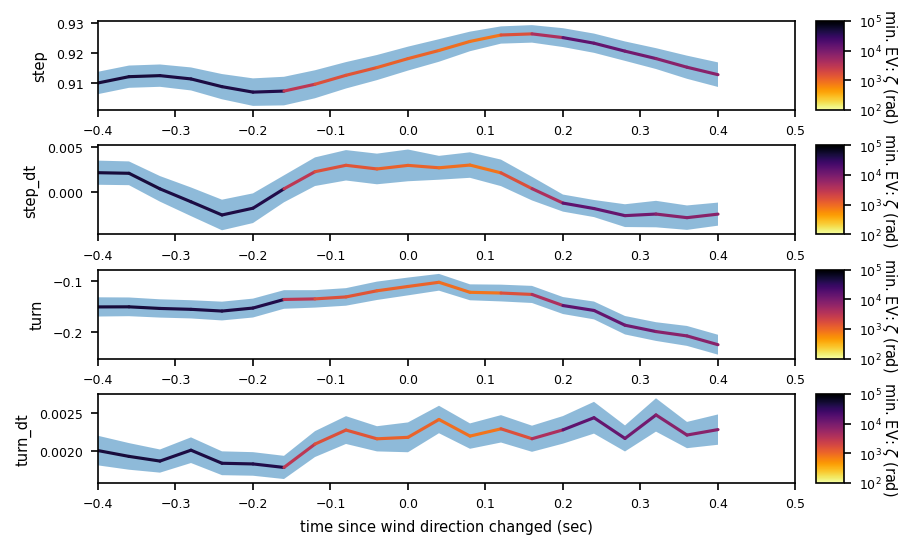

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline

# plot average of actions over time since last wind change
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan_around.copy()
# subset_df['turn_dt'].fillna(0, inplace=True) # try dropping the first nan at the first row. fillna on turn_dt, s.t. there the only nans are the first row of each episode in column step_dt
subset_df.dropna(inplace=True)                      # NOTE: this is to see if there high observability prior to wind change is due to the first row of each episode - not the case
subset_df = subset_df.groupby('plot_tidx')[['zeta', 'step', 'turn', 'step_dt', 'turn_dt']].mean().reset_index()
print(subset_df[10:30])
# dispersion std
subset_df['std_zeta'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['zeta']
subset_df['std_step'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['step']
subset_df['std_step_dt'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['step_dt']
subset_df['std_turn'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['turn']
subset_df['std_turn_dt'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['turn_dt']
# dispersion ste
subset_df['ste_zeta'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['zeta']
subset_df['ste_step'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['step']
subset_df['ste_step_dt'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['step_dt']
subset_df['ste_turn'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['turn']
subset_df['ste_turn_dt'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['turn_dt']
# x-axis
subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04
# states = ['step', 'turn', 'step_dt', 'turn_dt']
states = ['step', 'step_dt', 'turn', 'turn_dt' ]
n_state = len(states)

fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
ax = ax.reshape(-1, 1)
print(ax.shape)
cmap = 'inferno_r'
color_by = 'zeta'

# max, min, log, ticks for the colorbar
max_ev = np.max(subset_df[color_by].values)
min_ev = np.min(subset_df[color_by].values)
log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
print(f"max_ev {max_ev}, min_ev {min_ev}, log_tick_high {log_tick_high}, log_tick_low {log_tick_low}")
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    dispersion_col = 'ste_' + state_name
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['plot_tidx'], subset_df[state_name].values, subset_df[color_by].values,  # x, y, color 
              ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['plot_tidx'], 
                          subset_df[state_name].values-subset_df[dispersion_col], 
                          subset_df[state_name].values+subset_df[dispersion_col], 
                          alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + r'$\zeta$ (rad)', rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    # set y label
    # ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    # ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel(state_name, fontsize=7)
    # ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since wind direction changed (sec)', fontsize=7)
    a.set_xlim(subset_df['plot_tidx'].min(), subset_df['plot_tidx'].max() + 0.1)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

do nor drop the second NAN and calc step and turn diff

(4, 1)


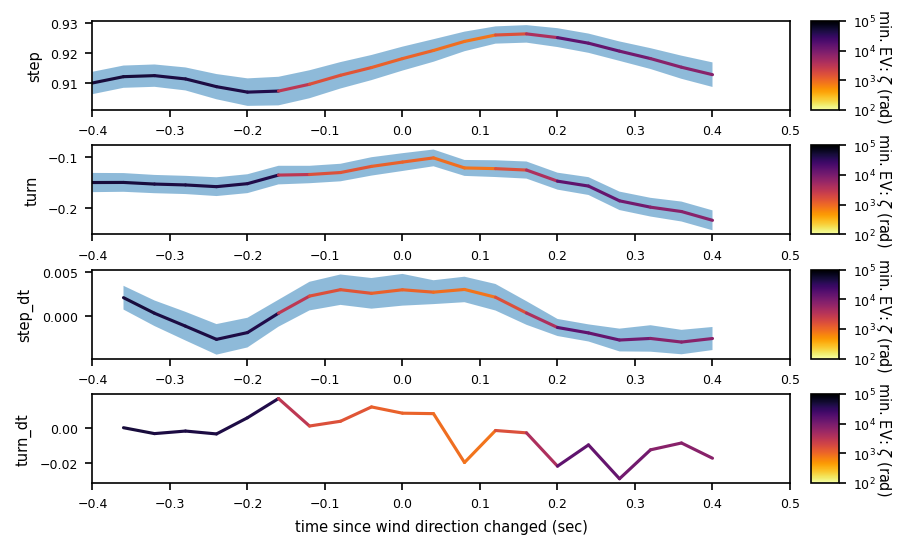

In [54]:
# plot average of actions over time since last wind change
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan_around.copy()
subset_df['turn_dt'].fillna(0, inplace=True) # try dropping the first nan at the first row. fillna on turn_dt, s.t. there the only nans are the first row of each episode in column step_dt
subset_df.dropna(inplace=True)                      # NOTE: this is to see if there high observability prior to wind change is due to the first row of each episode - not the case
# print(subset_df.head(10))
# subset_df.head(10)
subset_df = subset_df.groupby('plot_tidx')[['zeta', 'step', 'turn']].mean().reset_index()
subset_df['step_dt'] = subset_df['step'].diff()
subset_df['turn_dt'] = subset_df['turn'].diff()

# dispersion std
subset_df['std_zeta'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['zeta']
subset_df['std_step'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['step']
subset_df['std_step_dt'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['step_dt']
subset_df['std_turn'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['turn']
subset_df['std_turn_dt'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['turn_dt']
# dispersion ste
subset_df['ste_zeta'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['zeta']
subset_df['ste_step'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['step']
subset_df['ste_step_dt'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['step_dt']
subset_df['ste_turn'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['turn']
subset_df['ste_turn_dt'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['turn_dt']
# x-axis
subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04
states = ['step', 'step_dt']
states = ['step', 'turn', 'step_dt', 'turn_dt']
# states = ['step', 'turn']
n_state = len(states)

fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
ax = ax.reshape(-1, 1)
print(ax.shape)
cmap = 'inferno_r'
color_by = 'zeta'

# max, min, log, ticks for the colorbar
max_ev = np.max(subset_df[color_by].values)
min_ev = np.min(subset_df[color_by].values)
log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    dispersion_col = 'ste_' + state_name
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['plot_tidx'], subset_df[state_name].values, subset_df[color_by].values,  # x, y, color 
              ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['plot_tidx'], 
                          subset_df[state_name].values-subset_df[dispersion_col], 
                          subset_df[state_name].values+subset_df[dispersion_col], 
                          alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + r'$\zeta$ (rad)', rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    # set y label
    # ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    # ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel(state_name, fontsize=7)
    # ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since wind direction changed (sec)', fontsize=7)
    a.set_xlim(subset_df['plot_tidx'].min(), subset_df['plot_tidx'].max() + 0.1)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)
# plot vertical lines
# for a in ax.flat:
    # a.axvline(0.2, color='k', linestyle='--', alpha=0.5)
    # a.axvline(-0.16, color='k', linestyle='--', alpha=0.5)

plt.show()

(2, 1)


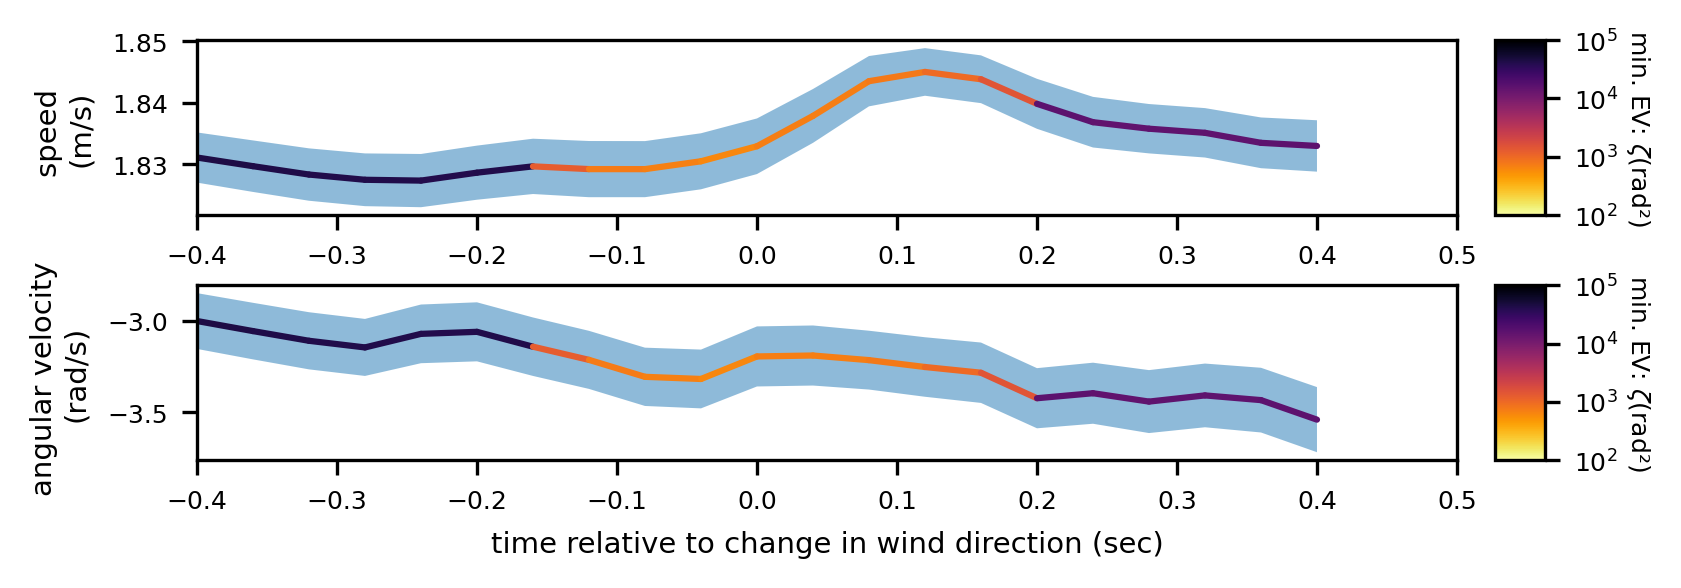

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline

ylabl_title = {'step': 'speed \n(m/s)', 'turn': 'angular velocity \n(rad/s)'}

# plot average of actions over time since last wind change
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan_around.copy()
subset_df['turn_dt'].fillna(0, inplace=True) # try dropping the first nan at the first row. fillna on turn_dt, s.t. there the only nans are the first row of each episode in column step_dt
subset_df.dropna(inplace=True)                      # NOTE: this is to see if there high observability prior to wind change is due to the first row of each episode - not the case
# print(subset_df.head(10))
subset_df.head(10)
subset_df = subset_df.groupby('plot_tidx')[['zeta', 'step', 'turn', 'step_dt', 'turn_dt']].mean().reset_index()
# translate to physical units
subset_df['step'] = subset_df['step'] * 2
subset_df['turn'] = subset_df['turn'] * 6 * np.pi
# dispersion std
tmp = EV_no_nan_around[['step', 'turn', 'plot_tidx']].copy() # physical units temporary
tmp['step'] = tmp['step'] * 2
tmp['turn'] = tmp['turn'] * 6 * np.pi

subset_df['std_zeta'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['zeta']
subset_df['std_step'] = tmp.groupby('plot_tidx').std().reset_index()['step']
subset_df['std_step_dt'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['step_dt']
subset_df['std_turn'] = tmp.groupby('plot_tidx').std().reset_index()['turn']
subset_df['std_turn_dt'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['turn_dt']
# dispersion ste
subset_df['ste_zeta'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['zeta']
subset_df['ste_step'] = tmp.groupby('plot_tidx').sem().reset_index()['step']
subset_df['ste_step_dt'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['step_dt']
subset_df['ste_turn'] = tmp.groupby('plot_tidx').sem().reset_index()['turn']
subset_df['ste_turn_dt'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['turn_dt']
# x-axis
subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04
states = ['step', 'turn']
# states = ['step', 'turn', 'step_dt', 'turn_dt']
n_state = len(states)

fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=300)
ax = np.atleast_2d(ax)
ax = ax.reshape(-1, 1)
print(ax.shape)
cmap = 'inferno_r'
color_by = 'zeta'

# max, min, log, ticks for the colorbar
max_ev = np.max(subset_df[color_by].values)
min_ev = np.min(subset_df[color_by].values)
log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    dispersion_col = 'ste_' + state_name
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['plot_tidx'], subset_df[state_name].values, subset_df[color_by].values,  # x, y, color 
              ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['plot_tidx'], 
                          subset_df[state_name].values-subset_df[dispersion_col], 
                          subset_df[state_name].values+subset_df[dispersion_col], 
                          alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + r'$\zeta$' + '(rad\u00B2)', rotation=270, fontsize=6, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    # set y label
    # ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    # ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel(ylabl_title[state_name], fontsize=7)
    # ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for i, a in enumerate(ax[:, 0]):
    if i == len(states) - 1:
        a.set_xlabel('time relative to change in wind direction (sec)', fontsize=7)
    a.set_xlim(subset_df['plot_tidx'].min(), subset_df['plot_tidx'].max() + 0.1)
fig.subplots_adjust(left=0.15, bottom=0.2, right=0.85, top=0.9, wspace=0.5, hspace=0.4)

# plt.show()
# plt.savefig('/src/tools/pybounds/examples/plots/14421_noisy_obs_40trials_nodrop.png')

do not drop 2nd NAN and plot median

(2, 1)


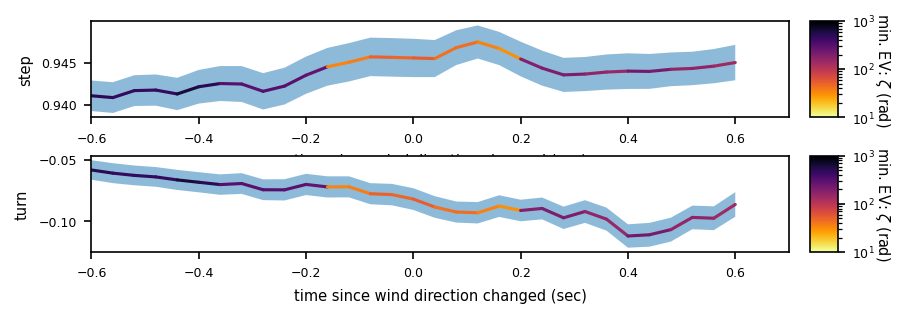

In [24]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline

# plot average of actions over time since last wind change
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan_around.copy()
subset_df['turn_dt'].fillna(0, inplace=True) # try dropping the first nan at the first row. fillna on turn_dt, s.t. there the only nans are the first row of each episode in column step_dt
subset_df.dropna(inplace=True)                      # NOTE: this is to see if there high observability prior to wind change is due to the first row of each episode - not the case
# print(subset_df.head(10))
subset_df.head(10)
subset_df = subset_df.groupby('plot_tidx')[['zeta', 'step', 'turn', 'step_dt', 'turn_dt']].median().reset_index()
# dispersion std
subset_df['std_zeta'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['zeta']
subset_df['std_step'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['step']
subset_df['std_step_dt'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['step_dt']
subset_df['std_turn'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['turn']
subset_df['std_turn_dt'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['turn_dt']
# dispersion ste
subset_df['ste_zeta'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['zeta']
subset_df['ste_step'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['step']
subset_df['ste_step_dt'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['step_dt']
subset_df['ste_turn'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['turn']
subset_df['ste_turn_dt'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['turn_dt']
# x-axis
subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04
states = ['step', 'turn']
# states = ['step', 'turn', 'step_dt', 'turn_dt']
n_state = len(states)

fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
ax = ax.reshape(-1, 1)
print(ax.shape)
cmap = 'inferno_r'
color_by = 'zeta'

# max, min, log, ticks for the colorbar
max_ev = np.max(subset_df[color_by].values)
min_ev = np.min(subset_df[color_by].values)
log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    dispersion_col = 'ste_' + state_name
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['plot_tidx'], subset_df[state_name].values, subset_df[color_by].values,  # x, y, color 
              ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['plot_tidx'], 
                          subset_df[state_name].values-subset_df[dispersion_col], 
                          subset_df[state_name].values+subset_df[dispersion_col], 
                          alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + r'$\zeta$ (rad)', rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    # set y label
    # ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    # ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel(state_name, fontsize=7)
    # ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since wind direction changed (sec)', fontsize=7)
    a.set_xlim(subset_df['plot_tidx'].min(), subset_df['plot_tidx'].max() + 0.1)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

### distr. of actions

In [6]:
subset_df = EV_no_nan_around.copy()
subset_df = subset_df[subset_df['plot_tidx'] < 5]
subset_df = subset_df[subset_df['plot_tidx'] > -5]
# subset_df.head(10)

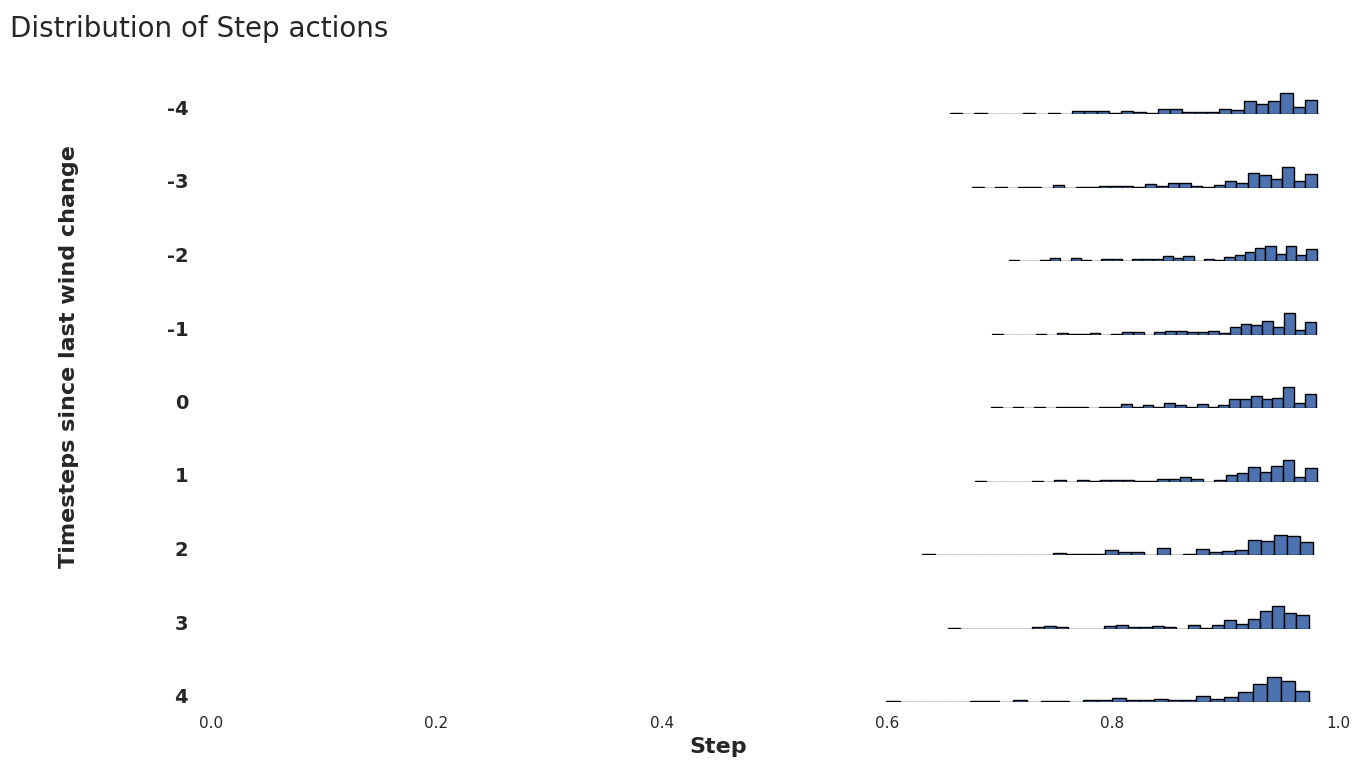

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
import matplotlib as mpl
from sklearn.neighbors import KernelDensity
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# create df
subset_df = EV_no_nan_around.copy()
subset_df = subset_df[subset_df['plot_tidx'] < 5]
subset_df = subset_df[subset_df['plot_tidx'] > -5]


plt_indices = [x for x in np.unique(subset_df['plot_tidx'])]

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
color_by = 'zeta'
color_values = subset_df[color_by]  # Replace 'your_continuous_column' with the actual column name
# Create a colormap and normalize the color variable
cmap = plt.get_cmap('inferno_r')  # Choose a colormap (e.g., 'viridis', 'plasma', 'coolwarm')
norm = Normalize(vmin=color_values.min(), vmax=color_values.max())  # Normalize the color variable

# max, min, log, ticks for the colorbar
max_ev = np.max(subset_df[color_by].values)
min_ev = np.min(subset_df[color_by].values)
log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)


gs = grid_spec.GridSpec(len(plt_indices),1)
fig = plt.figure(figsize=(16,9))

i = 0

ax_objs = []
for plot_tidx in plt_indices:
    x = np.array(subset_df[subset_df['plot_tidx'] == plot_tidx].step)
    color_value = subset_df[subset_df['plot_tidx'] == plot_tidx][color_by].mean()  # Use mean or another aggregation for the group

    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    
    # plotting the distribution
    # x_d = np.linspace(0,1, 1000)
    # kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
    # kde.fit(x[:, None])
    # logprob = kde.score_samples(x_d[:, None], )
    # ax_objs[-1].plot(x_d, np.exp(logprob),color="#f0f0f0",lw=1)
    # ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1) #,color=colors[i])

    # plotting the histogram 
    ax_objs[-1].hist(x, bins=30, alpha=1, edgecolor="black") #, color=cmap(cnorm(color_value)))

    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-0.1,1)
    ax_objs[-1].set_ylim(0,100)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if not plot_tidx:
        ax_objs[-1].set_ylabel("Timesteps since last wind change", fontsize=16,fontweight="bold")
        ax_objs[-1].yaxis.label.set_rotation(90)
    if i == len(plt_indices)-1:
        ax_objs[-1].set_xlabel("Step", fontsize=16,fontweight="bold")
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)
        
    ax_objs[-1].text(-0.02,0,plot_tidx,fontweight="bold",fontsize=14,ha="right")


    i += 1

gs.update(hspace=-0.3)

fig.text(0.07,0.85,"Distribution of Step actions",fontsize=20)

plt.tight_layout()
plt.show()

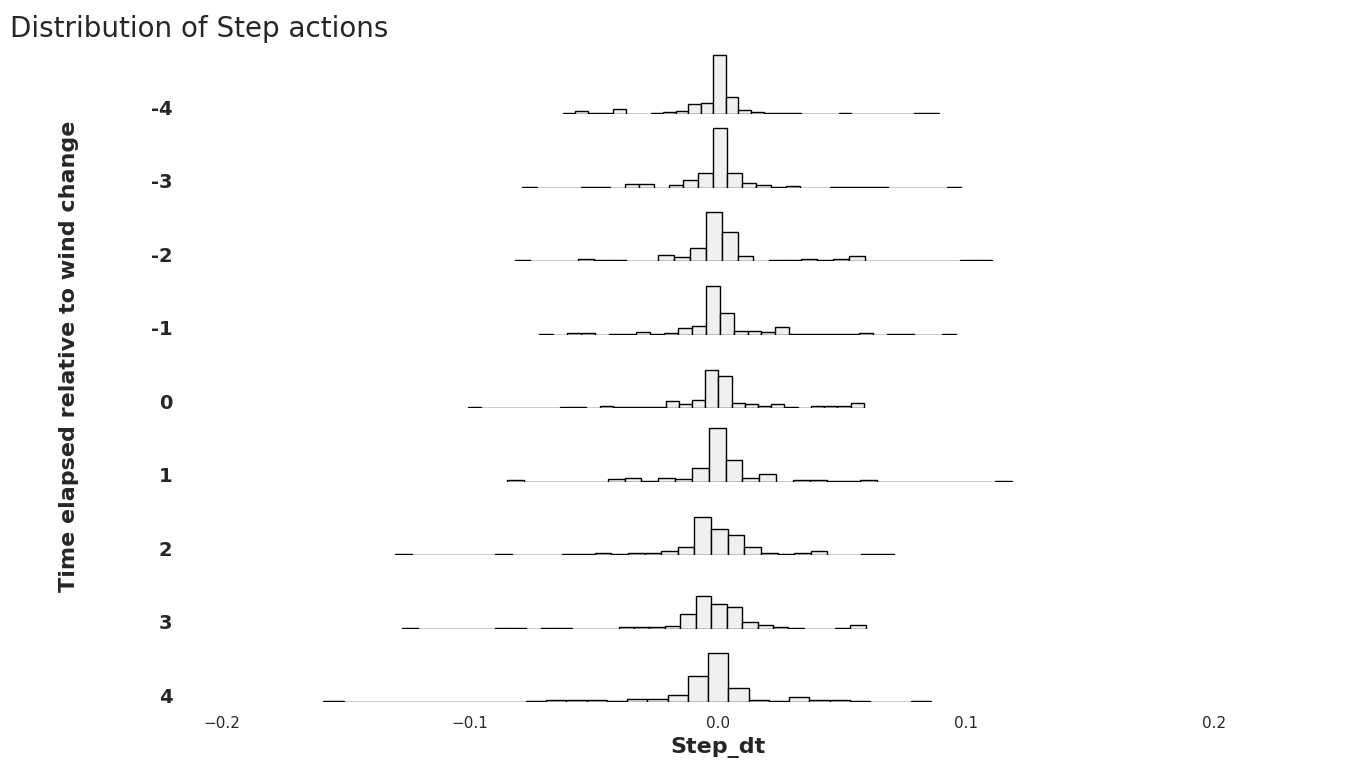

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from sklearn.neighbors import KernelDensity
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# create df
subset_df = EV_no_nan_around.copy()
subset_df = subset_df[subset_df['plot_tidx'] < 5]
subset_df = subset_df[subset_df['plot_tidx'] > -5]
subset_df.dropna(inplace=True)
plt_indices = [x for x in np.unique(subset_df['plot_tidx'])]
# colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']

gs = grid_spec.GridSpec(len(plt_indices),1)
fig = plt.figure(figsize=(16,9))

i = 0

ax_objs = []
for plot_tidx in plt_indices:
    x = np.array(subset_df[subset_df['plot_tidx'] == plot_tidx].step_dt)
    x_d = np.linspace(0,1, 1000)

    kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
    kde.fit(x[:, None])

    logprob = kde.score_samples(x_d[:, None], )

    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    # ax_objs[-1].plot(x_d, np.exp(logprob),color="#f0f0f0",lw=1)
    # ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1) #,color=colors[i])

    # plotting the histogram
    ax_objs[-1].hist(x, bins=30, color="#f0f0f0", alpha=1, edgecolor="black")

    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-0.25,0.25)
    ax_objs[-1].set_ylim(0,100)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if not plot_tidx:
        ax_objs[-1].set_ylabel("Time elapsed relative to wind change", fontsize=16,fontweight="bold")
        # rotate y label to vertical
        ax_objs[-1].yaxis.label.set_rotation(90)

    if i == len(plt_indices)-1:
        ax_objs[-1].set_xlabel("Step_dt", fontsize=16,fontweight="bold")

    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    ax_objs[-1].text(-0.22,0,plot_tidx,fontweight="bold",fontsize=14,ha="right")


    i += 1

gs.update(hspace=-0.3)

fig.text(0.07,0.85,"Distribution of Step actions",fontsize=20)

plt.tight_layout()
plt.show()

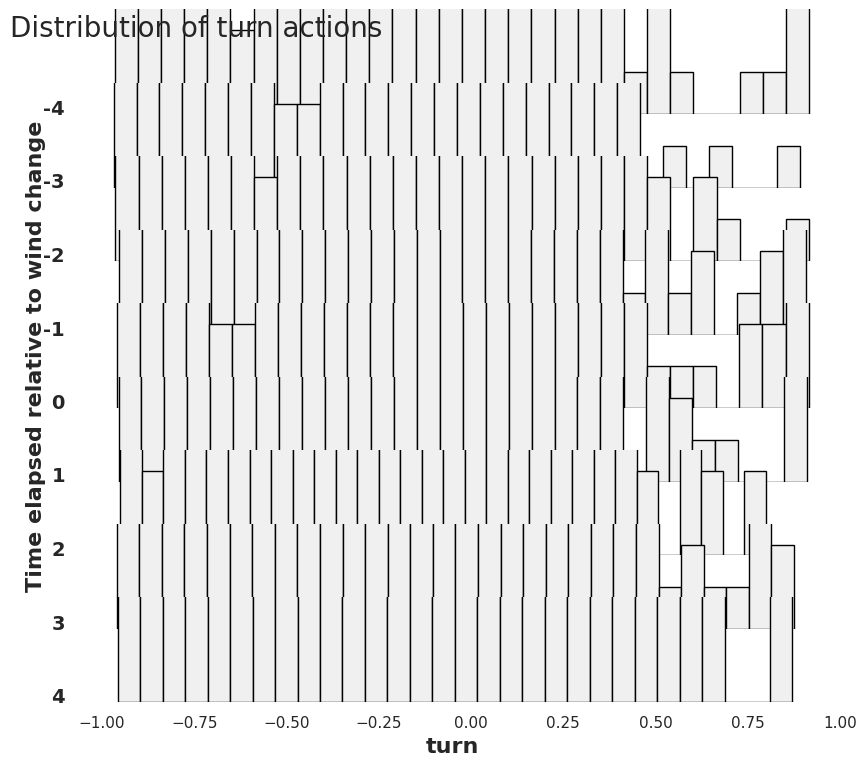

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
from sklearn.neighbors import KernelDensity
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# create df
subset_df = EV_no_nan_around.copy()
subset_df = subset_df[subset_df['plot_tidx'] < 5]
subset_df = subset_df[subset_df['plot_tidx'] > -5]
subset_df.dropna(inplace=True)
plt_indices = [x for x in np.unique(subset_df['plot_tidx'])]
# colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']

gs = grid_spec.GridSpec(len(plt_indices),1)
fig = plt.figure(figsize=(10,9))

i = 0

ax_objs = []
for plot_tidx in plt_indices:
    x = np.array(subset_df[subset_df['plot_tidx'] == plot_tidx].turn)
    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    # x_d = np.linspace(0,1, 1000)
    # kde = KernelDensity(bandwidth=0.03, kernel='gaussian')
    # kde.fit(x[:, None])
    # logprob = kde.score_samples(x_d[:, None], )
    # ax_objs[-1].plot(x_d, np.exp(logprob),color="#f0f0f0",lw=1)
    # ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1) #,color=colors[i])

    # plotting the histogram
    ax_objs[-1].hist(x, bins=30, color="#f0f0f0", alpha=1, edgecolor="black")

    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-1.1,1)
    ax_objs[-1].set_ylim(0,2.5)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if not plot_tidx:
        ax_objs[-1].set_ylabel("Time elapsed relative to wind change", fontsize=16,fontweight="bold")
        # rotate y label to vertical
        ax_objs[-1].yaxis.label.set_rotation(90)

    if i == len(plt_indices)-1:
        ax_objs[-1].set_xlabel("turn", fontsize=16,fontweight="bold")

    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    ax_objs[-1].text(-1.1,0,plot_tidx,fontweight="bold",fontsize=14,ha="right")


    i += 1

gs.update(hspace=-0.3)

fig.text(0.07,0.85,"Distribution of turn actions",fontsize=20)

plt.tight_layout()
plt.show()

## plot at odor contact duration

## add odor contact duration

In [12]:
# time since last encounter
def _count_lenc(lenc0, maxcount=None):
    count = 0
    lenc = []
    for i in range(len(lenc0)):
        count = 0 if lenc0[i] == 0 else count+1
        # print(i, lenc0[i], count)
        if maxcount is not None:
            count = maxcount if count >= maxcount else count
        lenc.append(count)
    return lenc
# traj_df['odor_lastenc'] = _count_lenc( 1 - traj_df['odor_01'], maxcount=15 )
EV_no_nan['odor_01_duration'] = _count_lenc(EV_no_nan['odor_01'], maxcount=None )
EV_no_nan['odor_01_duration'] = EV_no_nan['odor_01_duration'] * 0.04 # 0.04s per step
#  _count_lenc(EV_no_nan[EV_no_nan['ep_idx'] == 160]['odor_01'], maxcount=None )

EV_no_nan[EV_no_nan['ep_idx'] == 118].tail(10)


,time,time_initial,v_para,v_perp,w,zeta,ep_idx,time_since_last_wind_change,odor_lastenc,odor_01,step,turn,step_dt,turn_dt,loc_x,loc_y,odor_01_duration


## plot around odor contact

In [23]:
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan
subset_df = subset_df.groupby('odor_01_duration')['zeta'].mean().reset_index()
print(subset_df.head(10))
subset_df['std'] = EV_no_nan.groupby('odor_01_duration').std().reset_index()['zeta']
subset_df['ste'] = EV_no_nan.groupby('odor_01_duration').sem().reset_index()['zeta']
states = ['zeta']
n_state = len(states)
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline
fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
print(ax.shape)
cmap = 'inferno_r'

max_ev = np.max(subset_df['zeta'].values)
min_ev = np.min(subset_df['zeta'].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['odor_01_duration'], subset_df[state_name].values, subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['odor_01_duration'], subset_df[state_name].values-subset_df['ste'], subset_df[state_name].values+subset_df['ste'], alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('odor contact duration (s)', fontsize=7)
    a.set_xlim(-0.1, subset_df['odor_01_duration'].max() + 0.1)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

KeyError: 'odor_01_duration'

## plot at +- odor 

### preprocess

In [ ]:
# based on /src/JH_boilerplate/agent_evaluatiion/wind_encoding_perturbation/anno_around_plume_contact.ipynb

# find segments of continous odor contact, after filling the small gaps; NOTE: Start with ep_idx, odor_01, odor_lastenc, time
# 0. for every eps, find on-plume rows
EV_no_nan_on_plume = EV_no_nan.groupby('ep_idx', as_index=False).apply(lambda x: x[x['odor_01'] == 1])
EV_no_nan_on_plume.index = [i[1] for i in EV_no_nan_on_plume.index] # drop the eps_index level of the multiindex
# 1. fill plume enc gaps that are 1 timestep long
# check if there are any gaps in the plume encodings - how far apart are the on-plume timesteps?
delta_t_val = EV_no_nan_on_plume.groupby('ep_idx')['time'].diff()
delta_t_val.fillna(0.04, inplace=True) # first step in each episode is always 0.04 so fill na
delta_t_val = delta_t_val.round(2) # round to 2 decimal places such that all 0.04 are the same
tol_odor_gap_steps = 1 # 1 step gap is allowed during plume enc
idx_small_gaps_to_fill = delta_t_val[delta_t_val == 0.04*(tol_odor_gap_steps+1)].index # if within tolerance, consider it as 0.04
# the actual filling of the gaps
if EV_no_nan_on_plume.loc[idx_small_gaps_to_fill]['odor_01'].sum() == 0:
    print('as expected, all gaps have no odor')
EV_no_nan_on_plume.loc[idx_small_gaps_to_fill]['odor_lastenc'] == tol_odor_gap_steps
EV_no_nan_on_plume.loc[idx_small_gaps_to_fill]['odor_01'] = 1

# find segments of continous odor contact, after filling the small gaps
ls_odor_contact_start = []
ls_odor_contact_end = []
end_of_section_idx = [i for i in delta_t_val[delta_t_val != 0.04].index] 
for now_eps, group_df in EV_no_nan.groupby('ep_idx', as_index=False): # do this per eps to ensure there's no cross over of eps
    curr_marks = [i for i in end_of_section_idx if i < group_df.index.max() and i > group_df.index.min()]
    session_start = [group_df.index.min(), *curr_marks]
    session_end = [*curr_marks, group_df.index.max()]
    for i, now_section_idx in enumerate(zip(session_start, session_end)): # each session contains one segment of continuous odor contact
        section_df = group_df.loc[now_section_idx[0]:now_section_idx[1]-1] # .loc is end inclusive - so remove 1 to exclude the first ts of next odor encounter    
        plume_enc_df = section_df[section_df['odor_01'] == 1] # each section contains one continuous plume encounter
        if not plume_enc_df.empty:
            # pull out indices of the start and end of the plume encounter
            odor_contact_start = plume_enc_df.index[0]
            odor_contact_end = plume_enc_df.index[-1]
            ls_odor_contact_start.append(odor_contact_start)
            ls_odor_contact_end.append(odor_contact_end)
            # # SANITY CHECK PASSED around the plume encounter, there should not be any odor, if those steps are in the same episode as the plume encounter
            # if i:
            #     start_minus_one = group_df.loc[odor_contact_start - 1]
            #     assert start_minus_one['odor_01'] == 0, f"the step before odor encounter df {now_section_idx} {start_minus_one} is on odor!"
            # end_plus_one = traj_df_stacked.loc[odor_contact_end + 1]
            # if end_plus_one['ep_idx'] == now_eps:
            #     if (odor_contact_end + 1) != group_df.index.max(): # last step is cut off - it could be on plume. This is fine
            #         assert end_plus_one['odor_01'] == 0, f"the step after end of odor encounter df {now_section_idx} {end_plus_one} is on odor!"
            #     # the step after end of odor encounter df (704, 707) loc_x   


def tidx_around_odor_contact(df_traj, around_range=5, drop_incomplete=True, verbose=False):
    # df_traj contains minEV zeta, ep_idx, odor_contact_start; currently only works if dropping incomplete, hence filling small gaps of 1 frame
    
    # get +- around_range index around which odor contact started or ended
    # returns df_traj_aligned: a subset of df_traj, with only the rows around which wind changed, and plot_tidx around wind change, instead of actual tidx
    idx_where_odor_changed = df_traj[df_traj['odor_contact_start']==0].index
    if verbose:
        print(f"starting with df.shape {df_traj.shape}")
        print(f"with {df_traj['ep_idx'].nunique()} eps")
        print(f"total number of start of odor contact {len(idx_where_odor_changed)}")
    if drop_incomplete:
        print(f"dropping incomplete time windows, where +- {around_range} around odor change is out of range")
    
    # get index around which odor changed
    df_traj_grouped = df_traj.groupby('ep_idx')
    idx_around_wind_change = []
    tidx_for_plotting = []
    eligible_odor_start_idx = []
    for _, ep_df in df_traj_grouped:
        idx_where_odor_changed = ep_df[ep_df['odor_contact_start']==1].index
        for odor_changed_idx in idx_where_odor_changed:
            # check if -5/+5 is out of range
            upper_bound = odor_changed_idx + around_range
            lower_bound = odor_changed_idx - around_range
            if upper_bound >= ep_df.index.max():
                if drop_incomplete:
                    continue
                upper_bound = ep_df.index.max()
            if lower_bound < ep_df.index.min():
                if drop_incomplete: 
                    continue
                lower_bound = ep_df.index.min()
            # get index around which odor changed
            now_idx_range = [i for i in range(lower_bound, upper_bound + 1)] # loc index of rows around wind change
            # check if that bleeds into other odor contact windows - TODO: currently only works if dropping incomplete
            assert drop_incomplete, "odor contact alignment only works if dropping incomplete for now"
            if (ep_df.loc[lower_bound:odor_changed_idx-1]['odor_01'].eq(1).any()): # if there is a 1 in the window
                # print(f"skip due to 1 in {ep_df.loc[lower_bound:odor_changed_idx-1]['odor_01']}")
                continue 
            elif (ep_df.loc[odor_changed_idx:upper_bound]['odor_01'].eq(0)).any(): # if there is a 0 in the window
                # print(f"skip due to 0 in {ep_df.loc[odor_changed_idx:upper_bound]['odor_01']}")
                continue
            idx_around_wind_change.append(now_idx_range)
            tidx_for_plotting.append(list(np.array(now_idx_range) - odor_changed_idx)) # time index aligned to wind change, where wind change is 0 and prior to wind change is negative
            eligible_odor_start_idx.append(odor_changed_idx)
    # subset df and add plot_tidx
    idx_around_wind_change = [item for sublist in idx_around_wind_change for item in sublist]
    sub_df = df_traj.loc[idx_around_wind_change]
    sub_df['plot_tidx'] = [item for sublist in tidx_for_plotting for item in sublist]
    print(f"[NOTE]: number of eligible unique wind change instances {len(set(eligible_odor_start_idx))}")
    if verbose:
        print(f"returning sub_df.shape {sub_df.shape}")
        print(f"with {sub_df['ep_idx'].nunique()} eps")
        # intersection bewteen eps in sub_df and eps in df_traj
        print(f"eps {set(df_traj['ep_idx'].unique()) - set(sub_df['ep_idx'].unique())} did not have any eligible odor contact windows")
    return sub_df

# add cols for tidx_around_odor_contact
EV_no_nan_around = EV_no_nan.copy()
EV_no_nan_around['odor_contact_start'] = 0
EV_no_nan_around['odor_contact_end'] = 0
EV_no_nan_around.loc[ls_odor_contact_start, 'odor_contact_start'] = 1
EV_no_nan_around.loc[ls_odor_contact_end, 'odor_contact_end'] = 1
# tidx_around_odor_contact
EV_no_nan_around = tidx_around_odor_contact(EV_no_nan_around, around_range=40, drop_incomplete=True, verbose=True)


In [77]:
EV_no_nan_around['zeta_log'] = np.log10(EV_no_nan_around['zeta'])

In [ ]:
EV_no_nan_around['ep_idx'].unique()


In [ ]:
EV_no_nan_around[EV_no_nan_around['ep_idx']==235][5:40]

In [ ]:
minEV_tidx_range = np.array([-1.44, -1.24]) / 0.04
# find the distribution of time since last wind change for the minEV range
EV_no_nan_around[(EV_no_nan_around['plot_tidx'] > minEV_tidx_range[0]) & (EV_no_nan_around['plot_tidx'] < minEV_tidx_range[1])]['time_since_last_wind_change'].hist(bins=100)

In [ ]:
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan_around
subset_df = subset_df.groupby('plot_tidx')['zeta'].mean().reset_index()
print(subset_df.head(10))
subset_df['std'] = EV_no_nan_around.groupby('plot_tidx').std().reset_index()['zeta']
subset_df['ste'] = EV_no_nan_around.groupby('plot_tidx').sem().reset_index()['zeta']
subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04
states = ['zeta']
n_state = len(states)
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline
fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
print(ax.shape)
cmap = 'inferno_r'

max_ev = np.max(subset_df['zeta'].values)
min_ev = np.min(subset_df['zeta'].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['plot_tidx'], subset_df[state_name].values, subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['plot_tidx'], subset_df[state_name].values-subset_df['ste'], subset_df[state_name].values+subset_df['ste'], alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since odor encounter (sec)', fontsize=7)
    a.set_xlim(subset_df['plot_tidx'].min(), subset_df['plot_tidx'].max() + 0.1)

# plot vline 
# for a in ax.flat:
    # a.axvline(-1.24, color='red', linestyle='--', linewidth=0.5)
    # a.axvline(-1.44, color='red', linestyle='--', linewidth=0.5)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

# minEV shift window

## preprocess

In [200]:
EV_no_nan_shifted = EV_no_nan.copy()
window_length = 10
print(EV_no_nan_shifted.columns)
print(EV_no_nan_shifted.shape)
# EV_no_nan_shifted.groupby('ep_idx')['zeta'].apply()


EV_no_nan_shifted['zeta_shifted'] = EV_no_nan_shifted.groupby('ep_idx')['zeta'].shift(int(window_length/2))
EV_no_nan_shifted['zeta_shifted_qcut'] = EV_no_nan_shifted['zeta_shifted'].transform(lambda x: pd.qcut(x, q=10, labels=False))
EV_no_nan_shifted['zeta_shifted_qcut_per_eps'] = EV_no_nan_shifted.groupby('ep_idx')['zeta_shifted'].transform(lambda x: pd.qcut(x, q=np.linspace(0, 1, num=100), duplicates='drop', labels=False))

# EV_no_nan_shifted.dropna(inplace=True)
# drop the first 10 idx in each episode
EV_no_nan_shifted = EV_no_nan_shifted.groupby('ep_idx').apply(lambda x: x.iloc[window_length:])
EV_no_nan_shifted = EV_no_nan_shifted.droplevel(0)
print(EV_no_nan_shifted.shape)
# EV_no_nan_shifted[EV_no_nan_shifted['ep_idx'] == 773].head(15)

Index(['time', 'time_initial', 'v_para', 'v_perp', 'w', 'zeta', 'ep_idx',
       'time_since_last_wind_change', 'odor_lastenc', 'odor_01', 'step',
       'turn', 'step_dt', 'turn_dt', 'loc_x', 'loc_y',
       'wind_angle_ground_theta'],
      dtype='object')
(65346, 17)
(61806, 20)


In [201]:
# based on /src/JH_boilerplate/agent_evaluatiion/wind_encoding_perturbation/analyze_OL_perturb_trajj.ipynb
def tidx_around_wind_change(df_traj, around_range=40, drop_incomplete=True, drop_close_to_trial_init=False, verbose=False):
    # df_traj contains the KL divergence data and the time since the last wind change
    # get +- around_range index around which wind changed
    # returns df_traj_aligned: a subset of df_traj, with only the rows around which wind changed, and plot_tidx around wind change, instead of actual tidx
        # drop_close_to_trial_init: plot_tidx marking is invalid if the wind change time is too close to the trial init, -40 plot_tidx could mean 0.8s from the last wind change
            # this option checks the lowest bound of the plot_tidx, if its corresponding time is less than 1s, drop the whole window
    idx_where_wind_changed = df_traj[df_traj['time_since_last_wind_change']==0].index
    if verbose:
        print(f"starting with df.shape {df_traj.shape}")
        print(f"with {df_traj['ep_idx'].nunique()} eps")
        # max_rep = np.max(np.array([int(hash.split('_')[-2]) for hash in df_traj['ep_idx']])) + 1
        # print(f"and up to {max_rep} reps")
        print(f"total number of wind change {len(idx_where_wind_changed)}")
    if drop_incomplete:
        print(f"dropping incomplete time windows, where +- {around_range} around wind change is out of range")
    
    # get index around which wind changed
    df_traj_grouped = df_traj.groupby('ep_idx')
    idx_around_wind_change = []
    tidx_for_plotting = []
    eligible_wind_change_idx = []
    drop_due_to_close_to_trial_init = 0
    for _, ep_df in df_traj_grouped:
        idx_where_wind_changed = ep_df[ep_df['time_since_last_wind_change']==0].index
        for i, wind_changed_idx in enumerate(idx_where_wind_changed):
            # check if -5/+5 is out of range
            upper_bound = wind_changed_idx + around_range
            lower_bound = wind_changed_idx - around_range
            if upper_bound >= ep_df.index.max():
                if drop_incomplete:
                    continue
                upper_bound = ep_df.index.max()
            if lower_bound < ep_df.index.min():
                if drop_incomplete: 
                    continue
                lower_bound = ep_df.index.min()
            # check if the time elasped at the lower bound is too close to trial init
            if ep_df['time'].loc[lower_bound] < 1:
                if drop_close_to_trial_init:
                    drop_due_to_close_to_trial_init += 1
                    continue
            # check if time_since_last_wind_change is 0 at the lower bound
            if ep_df['time_since_last_wind_change'].loc[lower_bound] < 1:
                # print(f"wind_changed_idx {wind_changed_idx},  {ep_df['time_since_last_wind_change'].loc[lower_bound]}, lower_bound {lower_bound}, {wind_changed_idx - lower_bound}")
                continue
            # check if between lower_bound and wind_changed_idx, time_since_last_wind_change is not 0
            if 0 in ep_df['time_since_last_wind_change'].loc[lower_bound:wind_changed_idx-1].values:
                continue
            if 0 in ep_df['time_since_last_wind_change'].loc[wind_changed_idx+1:upper_bound].values:
                continue
            # get index around which wind changed
            now_idx_range = [i for i in range(lower_bound, upper_bound + 1)] # loc index of rows around wind change
            idx_around_wind_change.append(now_idx_range)
            tidx_for_plotting.append(list(np.array(now_idx_range) - wind_changed_idx)) # time index aligned to wind change, where wind change is 0 and prior to wind change is negative
            eligible_wind_change_idx.append(wind_changed_idx)
    # subset df and add plot_tidx
    idx_around_wind_change = [item for sublist in idx_around_wind_change for item in sublist]
    sub_df = df_traj.loc[idx_around_wind_change]
    sub_df['plot_tidx'] = [item for sublist in tidx_for_plotting for item in sublist]
    print(f"[NOTE]: number of eligible unique wind change instances {len(set(eligible_wind_change_idx))}")
    if verbose:
        print(f"returning sub_df.shape {sub_df.shape}")
        print(f"with {sub_df['ep_idx'].nunique()} eps")
        # intersection bewteen eps in sub_df and eps in df_traj
        print("trials dropped due to being too close to trial init", drop_due_to_close_to_trial_init)
        print(f"eps {set(df_traj['ep_idx'].unique()) - set(sub_df['ep_idx'].unique())} did not have any eligible wind change windows")
    return sub_df

EV_no_nan_shifted_around = tidx_around_wind_change(EV_no_nan_shifted, around_range=15, drop_incomplete=True, drop_close_to_trial_init=True, verbose=True)
# EV_no_nan_shifted_around.head(10)

starting with df.shape (61806, 20)
with 354 eps
total number of wind change 2081
dropping incomplete time windows, where +- 15 around wind change is out of range


[NOTE]: number of eligible unique wind change instances 251
returning sub_df.shape (7781, 21)
with 242 eps
trials dropped due to being too close to trial init 0
eps {0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 17, 18, 20, 21, 22, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 48, 50, 53, 60, 61, 62, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 120, 121, 122, 126, 127, 132, 133, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 151, 152, 153, 155, 156, 157, 780, 781, 782, 321, 341, 346, 357, 440, 441, 442, 445, 446, 447, 448, 450, 451, 452, 455, 456, 460, 461, 462, 465, 466, 468, 470, 471, 472, 473, 475, 477} did not have any eligible wind change windows


### sanity check

Text(0.5, 1.0, 'time elapsed at plot_tidx = nan')

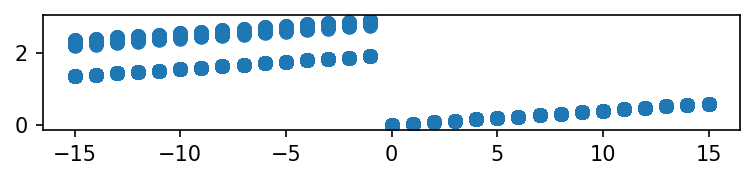

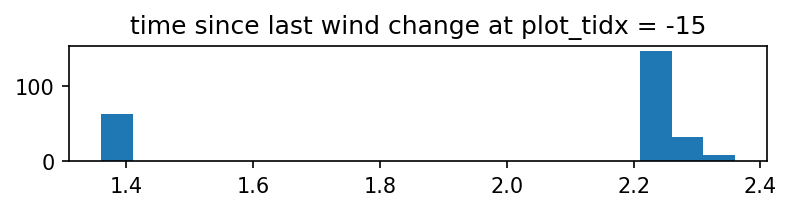

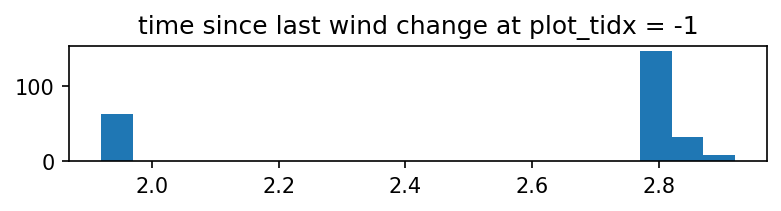

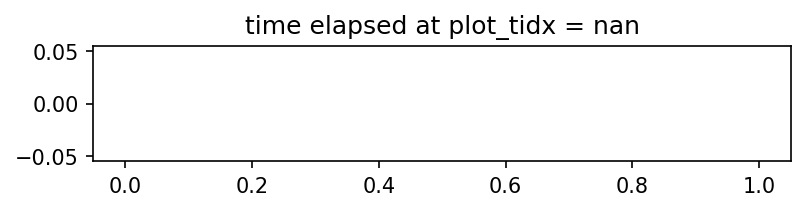

In [114]:
# plot y axis time since last wind change, x axis plot_tidx
import matplotlib.pyplot as plt
subset_df = EV_no_nan_shifted_around.copy()
fig, ax = plt.subplots(1, 1, figsize=(6, 1), dpi=150)

plt.scatter(subset_df['plot_tidx'], subset_df['time_since_last_wind_change'])

# plot histogram of time since last wind change at the smallest plot_tidx
subset_df = EV_no_nan_shifted_around.copy()
subset_df = subset_df[subset_df['plot_tidx'] == subset_df['plot_tidx'].min()]
fig, ax = plt.subplots(1, 1, figsize=(6, 1), dpi=150)
plt.hist(subset_df['time_since_last_wind_change'], bins=20)
plt.title(f"time since last wind change at plot_tidx = {subset_df['plot_tidx'].min()}")

# plot histogram of time since last wind change at the smallest plot_tidx
subset_df = EV_no_nan_shifted_around.copy()
subset_df = subset_df[subset_df['plot_tidx'] == -1]
fig, ax = plt.subplots(1, 1, figsize=(6, 1), dpi=150)
plt.hist(subset_df['time_since_last_wind_change'], bins=20)
plt.title(f"time since last wind change at plot_tidx = {subset_df['plot_tidx'].min()}")

# plot histogram of time since last wind change at the smallest plot_tidx
subset_df = EV_no_nan_shifted_around.copy()
subset_df = subset_df[subset_df['plot_tidx'] == -30]
fig, ax = plt.subplots(1, 1, figsize=(6, 1), dpi=150)
plt.hist(subset_df['time'], bins=20)
plt.title(f"time elapsed at plot_tidx = {subset_df['plot_tidx'].min()}") # use this to pick threshold for drop_close_to_trial_init


## avg. plots

### just obs

    plot_tidx  zeta_shifted
15       0.00  50048.981152
16       0.04   1338.899668
17       0.08   1304.259275
18       0.12   1169.525366
19       0.16   1058.852752
20       0.20    902.428574
21       0.24    785.688029
22       0.28    663.713762
23       0.32    993.558306
24       0.36   2236.546067
(1, 1)


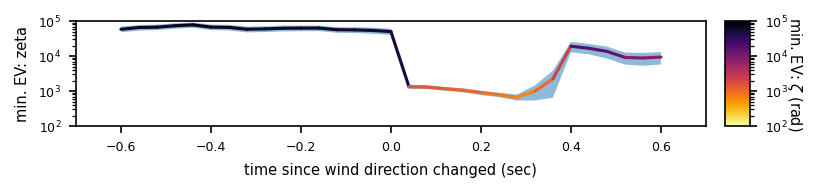

In [115]:
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan_shifted_around.copy()
# subset_df['turn_dt'].fillna(0, inplace=True) # try dropping the first nan at the first row. fillna on turn_dt, s.t. there the only nans are the first row of each episode in column step_dt
# subset_df.dropna(inplace=True)                      # NOTE: this is to see if there high observability prior to wind change is due to the first row of each episode - not the case
subset_df = subset_df.groupby('plot_tidx')['zeta_shifted'].mean().reset_index()
subset_df['std'] = EV_no_nan_shifted_around.groupby('plot_tidx').std().reset_index()['zeta_shifted']
subset_df['ste'] = EV_no_nan_shifted_around.groupby('plot_tidx').sem().reset_index()['zeta_shifted']
subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04
print(subset_df[['plot_tidx', 'zeta_shifted']][15:25])
# print(subset_df[['plot_tidx', 'zeta_shifted']][5:15])
states = ['zeta_shifted']
n_state = len(states)
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline
fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
print(ax.shape)
cmap = 'inferno_r'

max_ev = np.max(subset_df['zeta_shifted'].values)
min_ev = np.min(subset_df['zeta_shifted'].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['plot_tidx'], subset_df[state_name].values, subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['plot_tidx'], subset_df[state_name].values-subset_df['ste'], subset_df[state_name].values+subset_df['ste'], alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + r'$\zeta$ (rad)', rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 0].set_yscale('log')
    if state_name == 'zeta_shifted': state_name = 'zeta'
        
    ax[n, 0].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since wind direction changed (sec)', fontsize=7)
    a.set_xlim(subset_df['plot_tidx'].min() -0.1, subset_df['plot_tidx'].max() + 0.1)
    # greek letter zeta
    
fig.subplots_adjust(left=0.15, bottom=0.2, right=0.85, top=0.9, wspace=0.5, hspace=0.4)

# plt.show()
# plt.savefig('/src/tools/pybounds/examples/plots/obs.png')

### actions

    plot_tidx  zeta_shifted      step      turn   step_dt   turn_dt
10         -5  62917.715325  0.910658 -0.150919 -0.000099  0.041444
11         -4  63145.545921  0.911614 -0.138564  0.000956  0.036208
12         -3  56677.304714  0.914081 -0.131092  0.002467  0.049147
13         -2  56084.253801  0.916301 -0.130798  0.002220  0.052390
14         -1  53994.279024  0.916921 -0.136138  0.000620  0.041334
15          0  50048.981152  0.917187 -0.125060  0.000266  0.038970
16          1   1338.899668  0.918990 -0.106016  0.001804  0.045888
17          2   1304.259275  0.921410 -0.118728  0.002420  0.043494
18          3   1169.525366  0.922854 -0.114714  0.001444  0.049796
19          4   1058.852752  0.922226 -0.118695 -0.000628  0.041337
20          5    902.428574  0.920676 -0.141246 -0.001550  0.046266
21          6    785.688029  0.918968 -0.160557 -0.001708  0.047153
22          7    663.713762  0.917679 -0.176768 -0.001289  0.043957
23          8    993.558306  0.916668 -0.180192 

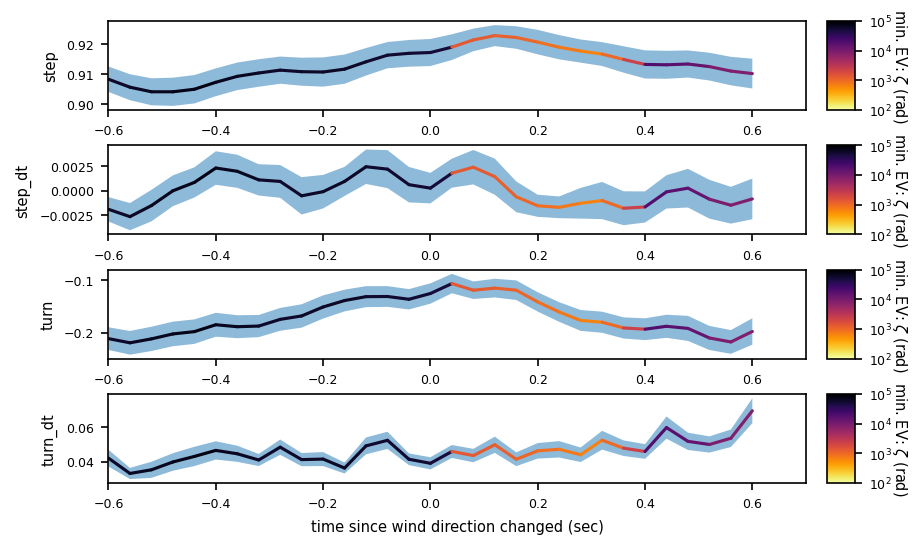

In [116]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline

# plot average of actions over time since last wind change
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan_shifted_around.copy()
# subset_df['turn_dt'].fillna(0, inplace=True) # try dropping the first nan at the first row. fillna on turn_dt, s.t. there the only nans are the first row of each episode in column step_dt
subset_df.dropna(inplace=True)                      # NOTE: this is to see if there high observability prior to wind change is due to the first row of each episode - not the case
subset_df = subset_df.groupby('plot_tidx')[['zeta_shifted', 'step', 'turn', 'step_dt', 'turn_dt']].mean().reset_index()
print(subset_df[10:30])
# dispersion std
subset_df['std_zeta_shifted'] = EV_no_nan_shifted_around.groupby('plot_tidx').std().reset_index()['zeta_shifted']
subset_df['std_step'] = EV_no_nan_shifted_around.groupby('plot_tidx').std().reset_index()['step']
subset_df['std_step_dt'] = EV_no_nan_shifted_around.groupby('plot_tidx').std().reset_index()['step_dt']
subset_df['std_turn'] = EV_no_nan_shifted_around.groupby('plot_tidx').std().reset_index()['turn']
subset_df['std_turn_dt'] = EV_no_nan_shifted_around.groupby('plot_tidx').std().reset_index()['turn_dt']
# dispersion ste
subset_df['ste_zeta_shifted'] = EV_no_nan_shifted_around.groupby('plot_tidx').sem().reset_index()['zeta_shifted']
subset_df['ste_step'] = EV_no_nan_shifted_around.groupby('plot_tidx').sem().reset_index()['step']
subset_df['ste_step_dt'] = EV_no_nan_shifted_around.groupby('plot_tidx').sem().reset_index()['step_dt']
subset_df['ste_turn'] = EV_no_nan_shifted_around.groupby('plot_tidx').sem().reset_index()['turn']
subset_df['ste_turn_dt'] = EV_no_nan_shifted_around.groupby('plot_tidx').sem().reset_index()['turn_dt']
# x-axis
subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04
# states = ['step', 'turn', 'step_dt', 'turn_dt']
states = ['step', 'step_dt', 'turn', 'turn_dt' ]
n_state = len(states)

fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
ax = ax.reshape(-1, 1)
print(ax.shape)
cmap = 'inferno_r'
color_by = 'zeta_shifted'

# max, min, log, ticks for the colorbar
max_ev = np.max(subset_df[color_by].values)
min_ev = np.min(subset_df[color_by].values)
log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
print(f"max_ev {max_ev}, min_ev {min_ev}, log_tick_high {log_tick_high}, log_tick_low {log_tick_low}")
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    dispersion_col = 'ste_' + state_name
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['plot_tidx'], subset_df[state_name].values, subset_df[color_by].values,  # x, y, color 
              ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['plot_tidx'], 
                          subset_df[state_name].values-subset_df[dispersion_col], 
                          subset_df[state_name].values+subset_df[dispersion_col], 
                          alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + r'$\zeta$ (rad)', rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    # set y label
    # ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    # ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel(state_name, fontsize=7)
    # ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since wind direction changed (sec)', fontsize=7)
    a.set_xlim(subset_df['plot_tidx'].min(), subset_df['plot_tidx'].max() + 0.1)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

### abs action_dots 

(4, 1)
max_ev 78005.46244007668, min_ev 663.7137619723471, log_tick_high 5, log_tick_low 2


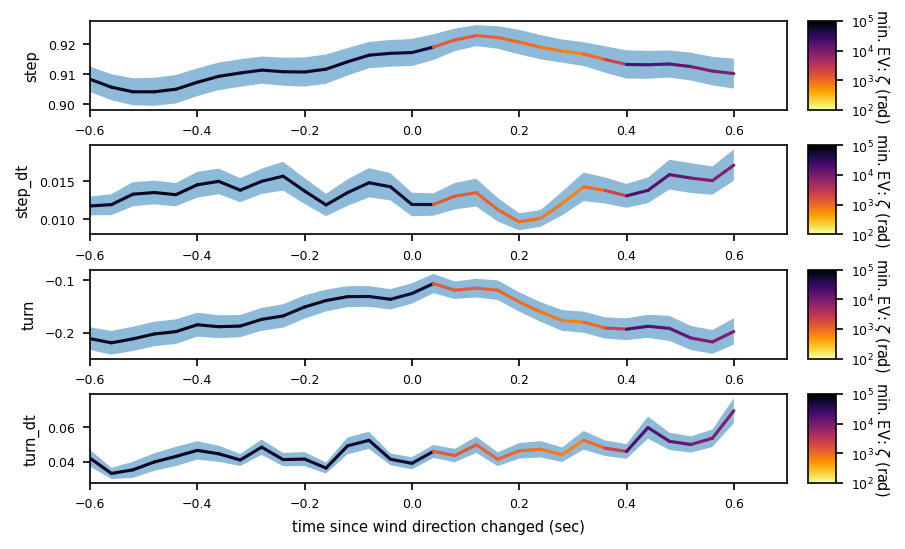

In [118]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline

# plot average of actions over time since last wind change
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan_shifted_around.copy()
# subset_df['turn_dt'].fillna(0, inplace=True) # try dropping the first nan at the first row. fillna on turn_dt, s.t. there the only nans are the first row of each episode in column step_dt
subset_df.dropna(inplace=True)                      # NOTE: this is to see if there high observability prior to wind change is due to the first row of each episode - not the case

subset_df['step_dt'] = subset_df['step_dt'].abs()
subset_df['turn_dt'] = subset_df['turn_dt'].abs()
subset_df = subset_df.groupby('plot_tidx')[['zeta_shifted', 'step', 'turn', 'step_dt', 'turn_dt']].mean().reset_index()
# print(subset_df[10:30])
# dispersion std
subset_df['std_zeta_shifted'] = EV_no_nan_shifted_around.groupby('plot_tidx').std().reset_index()['zeta_shifted']
subset_df['std_step'] = EV_no_nan_shifted_around.groupby('plot_tidx').std().reset_index()['step']
subset_df['std_step_dt'] = EV_no_nan_shifted_around.groupby('plot_tidx').std().reset_index()['step_dt']
subset_df['std_turn'] = EV_no_nan_shifted_around.groupby('plot_tidx').std().reset_index()['turn']
subset_df['std_turn_dt'] = EV_no_nan_shifted_around.groupby('plot_tidx').std().reset_index()['turn_dt']
# dispersion ste
subset_df['ste_zeta_shifted'] = EV_no_nan_shifted_around.groupby('plot_tidx').sem().reset_index()['zeta_shifted']
subset_df['ste_step'] = EV_no_nan_shifted_around.groupby('plot_tidx').sem().reset_index()['step']
subset_df['ste_step_dt'] = EV_no_nan_shifted_around.groupby('plot_tidx').sem().reset_index()['step_dt']
subset_df['ste_turn'] = EV_no_nan_shifted_around.groupby('plot_tidx').sem().reset_index()['turn']
subset_df['ste_turn_dt'] = EV_no_nan_shifted_around.groupby('plot_tidx').sem().reset_index()['turn_dt']
# x-axis
subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04
# states = ['step', 'turn', 'step_dt', 'turn_dt']
states = ['step', 'step_dt', 'turn', 'turn_dt' ]
n_state = len(states)

fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
ax = ax.reshape(-1, 1)
print(ax.shape)
cmap = 'inferno_r'
color_by = 'zeta_shifted'

# max, min, log, ticks for the colorbar
max_ev = np.max(subset_df[color_by].values)
min_ev = np.min(subset_df[color_by].values)
log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
print(f"max_ev {max_ev}, min_ev {min_ev}, log_tick_high {log_tick_high}, log_tick_low {log_tick_low}")
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    dispersion_col = 'ste_' + state_name
    # colorline(x_sim['x'], x_sim['y'], subset_df[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    colorline(subset_df['plot_tidx'], subset_df[state_name].values, subset_df[color_by].values,  # x, y, color 
              ax=ax[n, 0], cmap=cmap, norm=cnorm)
    # add std
    ax[n, 0].fill_between(subset_df['plot_tidx'], 
                          subset_df[state_name].values-subset_df[dispersion_col], 
                          subset_df[state_name].values+subset_df[dispersion_col], 
                          alpha=0.5)
    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + r'$\zeta$ (rad)', rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    # set y label
    # ax[n, 0].set_ylim(10**log_tick_low, 10**log_tick_high)
    # ax[n, 0].set_yscale('log')
    ax[n, 0].set_ylabel(state_name, fontsize=7)
    # ax[n, 0].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since wind direction changed (sec)', fontsize=7)
    a.set_xlim(subset_df['plot_tidx'].min(), subset_df['plot_tidx'].max() + 0.1)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

## traces plots

period_length 31
period
0      31
172    31
159    31
160    31
161    31
       ..
88     31
89     31
90     31
91     31
250    31
Name: count, Length: 251, dtype: int64


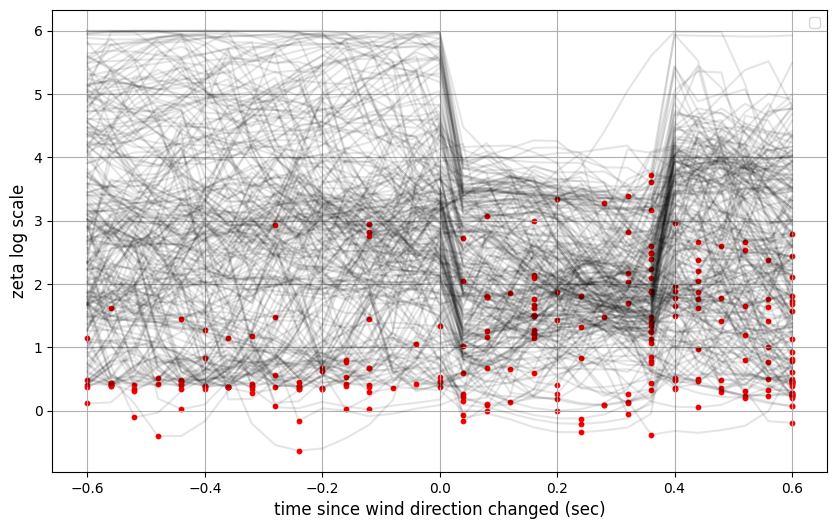

In [233]:
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan_shifted_around.copy()
subset_df.reset_index(inplace=True)
period_length = subset_df['plot_tidx'].max() - subset_df['plot_tidx'].min() + 1
print(f"period_length {period_length}")
subset_df['period'] = subset_df.index // (period_length)  # Assuming equal step size of 0.04
print(subset_df['period'].value_counts())
color_by = 'zeta_shifted'
max_ev = np.max(subset_df[color_by].values)
min_ev = np.min(subset_df[color_by].values)
log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))

# Plot each period as a separate trace
plt.figure(figsize=(10, 6))
for period, group in subset_df.groupby('period'):
    group.sort_values('plot_tidx', inplace=True)
    plt.plot(group['plot_tidx']*0.04, np.log10(group['zeta_shifted']), c='k', alpha=0.1)
    # plot a red dot at the minimum
    min_idx = group['zeta_shifted'].idxmin()
    plt.scatter(group.loc[min_idx, 'plot_tidx']*0.04, np.log10(group.loc[min_idx, 'zeta_shifted']), c='red', s=10)
    
    # plot green dot at the maximum
    # max_idx = group['zeta_shifted'].idxmax()
    # plt.scatter(group.loc[max_idx, 'plot_tidx']*0.04, np.log10(group.loc[max_idx, 'zeta_shifted']), c='green', s=10)
    
    # plot a blue dot at the biggest drop in zeta_shifted
    # diff_zeta = group['zeta_shifted'].diff()
    # max_diff_idx = diff_zeta.idxmin()
    # plt.scatter(group.loc[max_diff_idx, 'plot_tidx']*0.04, np.log10(group.loc[max_diff_idx, 'zeta_shifted']), c='blue', s=10)

# Add labels and legend
plt.xlabel('time since wind direction changed (sec)', fontsize=12)
plt.ylabel('zeta log scale', fontsize=12)
# plt.set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
plt.legend()
plt.grid(True)
plt.show()



### just obs

period_length 31
period
0      31
172    31
159    31
160    31
161    31
       ..
88     31
89     31
90     31
91     31
250    31
Name: count, Length: 251, dtype: int64


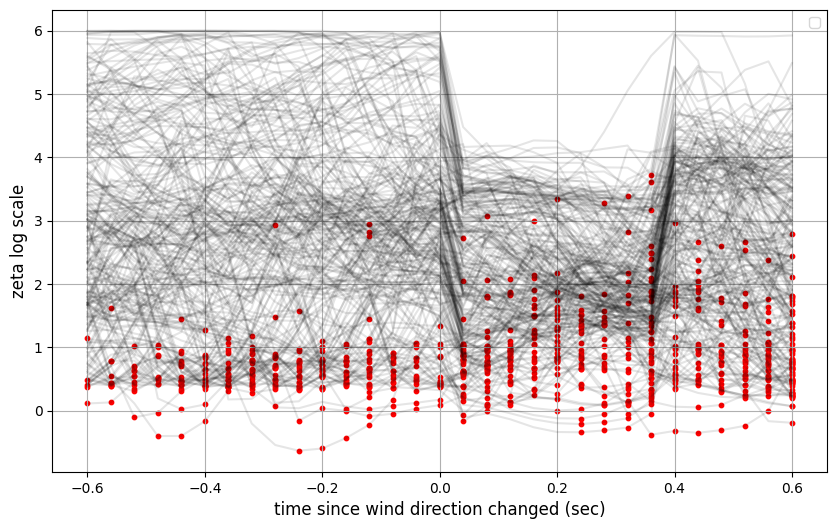

In [232]:
# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan_shifted_around.copy()
subset_df.reset_index(inplace=True)
period_length = subset_df['plot_tidx'].max() - subset_df['plot_tidx'].min() + 1
print(f"period_length {period_length}")
subset_df['period'] = subset_df.index // (period_length)  # Assuming equal step size of 0.04
print(subset_df['period'].value_counts())
color_by = 'zeta_shifted'
max_ev = np.max(subset_df[color_by].values)
min_ev = np.min(subset_df[color_by].values)
log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))

# Plot each period as a separate trace
plt.figure(figsize=(10, 6))
for period, group in subset_df.groupby('period'):
    group.sort_values('plot_tidx', inplace=True)
    plt.plot(group['plot_tidx']*0.04, np.log10(group['zeta_shifted']), c='k', alpha=0.1)
    # plot a red dot at the minimum
    min_idx = group['zeta_shifted'].idxmin()
    # plt.scatter(group.loc[min_idx, 'plot_tidx']*0.04, np.log10(group.loc[min_idx, 'zeta_shifted']), c='red', s=10)
    # plot a red dot at everywhere that is +- 100 from the minimum
    # Find all points within +-100 of the minimum
    min_zeta = group['zeta_shifted'].min()
    near_min_mask = (group['zeta_shifted'] <= min_zeta + 10)
    near_min_mask = (near_min_mask.index >= min_idx) & (near_min_mask)
    near_min_points = group[near_min_mask]
    
    # Plot red dots at these points
    plt.scatter(
        near_min_points['plot_tidx'] * 0.04,
        np.log10(near_min_points['zeta_shifted']),
        c='red', s=10
    )
    
    # plot green dot at the maximum
    # max_idx = group['zeta_shifted'].idxmax()
    # plt.scatter(group.loc[max_idx, 'plot_tidx']*0.04, np.log10(group.loc[max_idx, 'zeta_shifted']), c='green', s=10)
    
    # plot a blue dot at the biggest drop in zeta_shifted
    # diff_zeta = group['zeta_shifted'].diff()
    # max_diff_idx = diff_zeta.idxmin()
    # plt.scatter(group.loc[max_diff_idx, 'plot_tidx']*0.04, np.log10(group.loc[max_diff_idx, 'zeta_shifted']), c='blue', s=10)

# Add labels and legend
plt.xlabel('time since wind direction changed (sec)', fontsize=12)
plt.ylabel('zeta log scale', fontsize=12)
# plt.set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
plt.legend()
plt.grid(True)
plt.show()



### actions

period_length 31
period
0      31
172    31
159    31
160    31
161    31
       ..
88     31
89     31
90     31
91     31
250    31
Name: count, Length: 251, dtype: int64
(4, 1)
max_ev 995757.0089976537, min_ev 0.2323161165304669, log_tick_high 6, log_tick_low -1


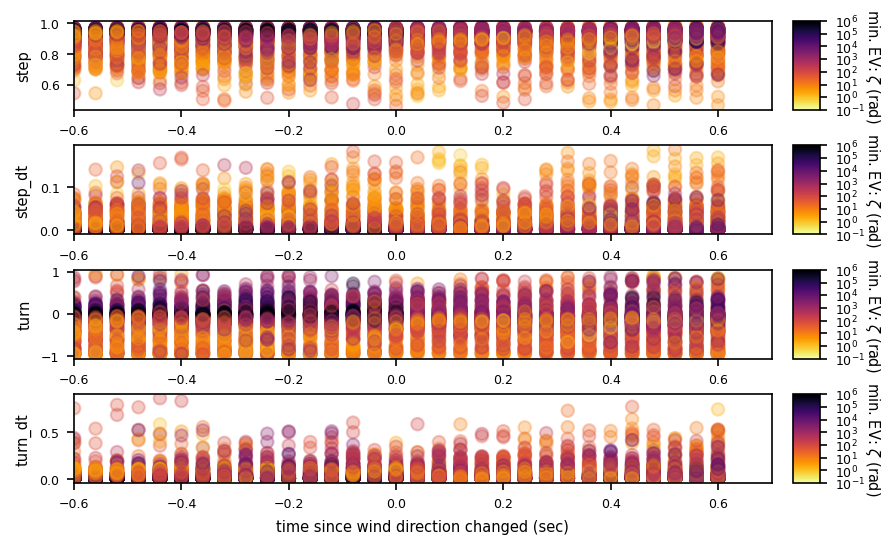

In [214]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from pybounds import colorline

# plot average EV over time since last wind change with std ON plume
subset_df = EV_no_nan_shifted_around.copy()
subset_df.reset_index(inplace=True)
period_length = subset_df['plot_tidx'].max() - subset_df['plot_tidx'].min() + 1
print(f"period_length {period_length}")
subset_df['period'] = subset_df.index // (period_length)  # Assuming equal step size of 0.04
print(subset_df['period'].value_counts())
color_by = 'zeta_shifted'
max_ev = np.max(subset_df[color_by].values)
min_ev = np.min(subset_df[color_by].values)
log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))

subset_df['step_dt'] = subset_df['step_dt'].abs()
subset_df['turn_dt'] = subset_df['turn_dt'].abs()
# x-axis
subset_df['plot_tidx'] = subset_df['plot_tidx'] * 0.04
# states = ['step', 'turn', 'step_dt', 'turn_dt']
states = ['step', 'step_dt', 'turn', 'turn_dt' ]
n_state = len(states)

fig, ax = plt.subplots(n_state, 1, figsize=(6, n_state*1), dpi=150)
ax = np.atleast_2d(ax)
ax = ax.reshape(-1, 1)
print(ax.shape)
cmap = 'inferno_r'
color_by = 'zeta_shifted'

# max, min, log, ticks for the colorbar
max_ev = np.max(subset_df[color_by].values)
min_ev = np.min(subset_df[color_by].values)
log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
print(f"max_ev {max_ev}, min_ev {min_ev}, log_tick_high {log_tick_high}, log_tick_low {log_tick_low}")
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    for period, group in subset_df.groupby('period'):
        group.sort_values('plot_tidx', inplace=True)
        ax[n, 0].scatter(group['plot_tidx'], group[state_name], c=group[color_by], norm=cnorm, cmap=cmap, alpha = 0.3)
    
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + r'$\zeta$ (rad)', rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    # set y label
    ax[n, 0].set_ylabel(state_name, fontsize=7)


for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    
for a in ax[:, 0]:
    a.set_xlabel('time since wind direction changed (sec)', fontsize=7)
    a.set_xlim(subset_df['plot_tidx'].min(), subset_df['plot_tidx'].max() + 0.1)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)

plt.show()

## quantize

period_length 31


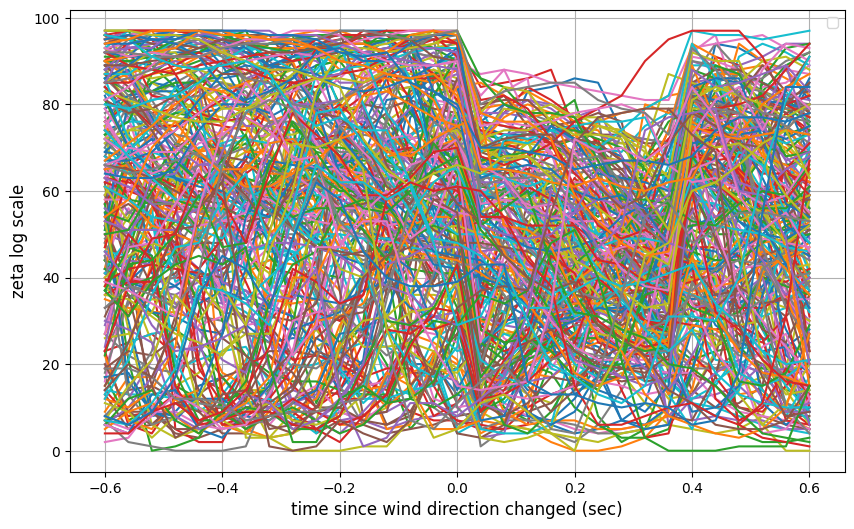

In [202]:
# # plot average EV over time since last wind change with std ON plume
# subset_df = EV_no_nan_shifted_around.copy()
# subset_df.reset_index(inplace=True)
# period_length = subset_df['plot_tidx'].max() - subset_df['plot_tidx'].min() + 1
# print(f"period_length {period_length}")
# subset_df['period'] = subset_df.index // (period_length)  # Assuming equal step size of 0.04
# # subset_df['zeta_shifted_qcut'] = subset_df.groupby('ep_idx')['zeta_shifted'].transform(lambda x: pd.qcut(x, q=10, labels=False))

# color_by = 'zeta_shifted_qcut_per_eps'
# max_ev = np.max(subset_df[color_by].values)
# min_ev = np.min(subset_df[color_by].values)
# # log_tick_high = int(np.ceil(np.log10(max_ev)))
# # log_tick_low = int(np.floor(np.log10(min_ev)))

# # Plot each period as a separate trace
# plt.figure(figsize=(10, 6))
# for period, group in subset_df.groupby('period'):
#     group.sort_values('plot_tidx', inplace=True)
#     plt.plot(group['plot_tidx']*0.04, group['zeta_shifted_qcut_per_eps'])

# # Add labels and legend
# plt.xlabel('time since wind direction changed (sec)', fontsize=12)
# plt.ylabel('zeta log scale', fontsize=12)
# # plt.set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
# plt.legend()
# plt.grid(True)
# plt.show()


# minEV distribution

In [ ]:
# log 10 transform EV_no_nan['zeta'] and then see its distribution
import seaborn as sns
sns.histplot(np.log10(EV_no_nan['zeta']), bins=1000)
np.log10(EV_no_nan['zeta']).describe()